# Оптимизация прибыльности виджета отзывов: анализ клиентской базы и тарифных стратегий

# Материалы:

* [Презентация](https://disk.yandex.ru/i/nOuzcTRVrPPjPQ)

- Компания разрабатывает виджеты для сбора отзывов и стремится повысить его прибыльность.

> **Цель проекта** — увеличить прибыльность виджета для сбора отзывов на основе анализа клиентской базы и тарифной системы, чтобы найти способы привлечь больше платных клиентов, удержать существующих и оптимизировать тарифную политику.

> **Задачи проекта:**
>
> *  Анализ данных: Предобработка, исследовательский и статистический анализ данных о пользователях и тарифах.
> *  Сегментация клиентов: Выделение ключевых сегментов на основе анализа данных.
> *  Разработка стратегии повышения прибыльности:>   *  Оптимизация тарифной системы
>   *  Разработка рекомендаций по привлечению, удержанию и монетизации клиентов.
> *  Презентация результатов: Подготовка и проведение презентации с выводами и реациями
>   комендациями.


> **Описание данных:**
>
> Для анализа используются данные, предоставленные заказчиком в формате JSON. Датасет состоит из четырех файлов, содержащих информацию о:
>
> *  `users`: Пользователи виджета (идентификационные данные, информация о тарифном плане, статус активности и т.д.).
> *  `plans`: Тарифные планы (название, стоимость, количество виджетов, срок действия и т.д.).
> *  `payments`: Платежи пользователей (идентификатор пользователя, тарифный план, сумма платежа, дата и статус платежа и т.д.).
> *  `widgets`: Виджеты, используемые пользователями (идентификатор виджета, рейтинг и т.д.).
>
>
> * Более подробная информация о структуре данных доступна по ссылке:
> * [Ссылка](https://disk.yandex.ru/i/a8IvoA2-YOXX3Q)

> **План проекта:**  
> <a id="plan-top"></a> <!-- Якорь для возврата к началу плана -->

> ***[1 Загрузка данных. Изучение общей информации](#section-1)***
> - [1.1 Обработка JSON-файлов](#section-1-1)  
> - [1.2 Сохранение DataFrame в CSV](#section-1-2)  
> - [1.3 Загрузка и просмотр данных](#section-1-3)  

> ---  
> ***[2 Предобработка данных](#section-2)***  
> - [2.1 Предобработка данных (`users`)](#section-2-1)  
> - [2.2 Предобработка данных (`plans`)](#section-2-2)  
> - [2.3 Предобработка данных (`payments`)](#section-2-3)  
> - [2.4 Предобработка данных (`widgets`)](#section-2-4)  

> ---  
> ***[3 Исследовательский анализ данных](#section-3)***  
> - [3.1 Анализ пользователей и тарифов](#section-3-1)  
> - [3.2 Анализ платежей](#section-3-2)  
> - [3.3 Сравнение динамики выручки](#section-3-3)  
> - [3.4 Анализ виджетов](#section-3-4)  
> - [3.5 Анализ активности клиентов](#section-3-5)  
> - [3.6 Анализ эффективности тарифов](#section-3-6)  
> - [3.7 Анализ оттока (Churn)](#section-3-7)  

> ---  
> ***[4 Проверка гипотез](#section-4)***
> - [4.1 Гипотеза о влиянии среднего количества виджетов на отток](#section-4-1) 
> - [4.2 Гипотеза о среднем рейтинге активных и ушедших пользователей](#section-4-2)  
> - [4.3 Гипотеза о влиянии платформы отзывов на отток](#section-4-3)    

> ---  
> ***[5 Сегментация пользователей](#section-5)***  

> ---  
> ***[6 Выводы и рекомендации](#section-6)***  

> [↑ Вернуться к плану](#plan-top) <!-- Ссылка для удобства -->

<a id="section-1"></a>
### 1 Загрузка данных. Изучение общей информации

In [9]:
# импорт библиотек

import pandas as pd
import json
import os
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 6)})
import plotly.express as px
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

<a id="section-1-1"></a>
#### 1.1 Обработка JSON-файлов

In [11]:
# Определяем константы
BASE_DIR = '.' 
DATA_DIR = os.path.join(BASE_DIR, 'data')
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed_data')

# Создаем папку для обработанных данных, если ее нет
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Безопасное извлечение данных из вложенной структуры
def safe_extract(data, keys, default=None):
    if not isinstance(data, dict):
        return default
    for key in keys:
        if not isinstance(data, dict) or key not in data:
            return default
        data = data[key]
    return data

In [12]:
# Функция для обработки JSON-файлов с учетом особенностей widgets
def process_json_file(file_path, fields):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            json_data = json.load(f)

        if not isinstance(json_data, list):
            json_data = [json_data] if json_data else []

        records = []
        for item in json_data:
            if not isinstance(item, dict):
                continue

            record = {}
            # Обработка основных полей
            for field_name, field_keys in fields.items():
                if isinstance(field_keys, list):
                    record[field_name] = safe_extract(item, field_keys)
                else:
                    record[field_name] = item.get(field_keys)
            
            # Специальная обработка для reviewAmount
            if 'reviewAmount' in item and isinstance(item['reviewAmount'], dict):
                for platform, count in item['reviewAmount'].items():
                    record[f'reviewAmount_{platform}'] = count
            
            # Специальная обработка для reviewStars
            if 'reviewStars' in item and isinstance(item['reviewStars'], dict):
                for star, count in item['reviewStars'].items():
                    record[f'reviewStars_{star}'] = count
            
            records.append(record)

        return pd.DataFrame(records)

    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {str(e)}")
        return pd.DataFrame() 
   

In [13]:
# Конфигурация обработки файлов
FILE_CONFIG = {
    'users': {
        'filename': 'users-26.03.25.json',
        'fields': {
            'user_id': ['_id', '$oid'],
            'widgets': ['widgets'],
            'role': 'role',
            'createdAt': ['createdAt', '$date'],
            'updatedAt': ['updatedAt', '$date'],
            'planName': ['plan', 'name'],
            'widgetsCount': ['plan', 'widgetsCount'],
            'planFinishedAt': ['plan', 'finishedAt', '$date'],
            'planPurchaseDate': ['plan', 'purchaseDate', '$date'],
            'planIsActive': ['plan', 'isActive'],
            'planIsTrial': ['plan', 'isTrial']
        }
    },
    'plans': {
        'filename': 'plans.json',
        'fields': {
            'plan_id': ['_id', '$oid'],
            'name': 'name',
            'widgetsCount': 'widgetsCount',
            'value_rub': 'value',
            'months': 'months',
            'custom': 'custom',
            'is_trial': 'isTrial'
        }
    },
    'payments': {
        'filename': 'payments.json',
        'fields': {
           'payment_id': ['_id', '$oid'],
            'order_id': 'orderId',
            'status': 'status',
            'createdAt': ['createdAt', '$date'],
            'plan_id': ['details', 'planId'],
            'planName': ['details', 'planName'],
            'amount': ['details', 'amount'],
            'months': ['details', 'months']
        }
    },
    'widgets': {
    'filename': 'widgets.json',
    'fields': {
        'widget_id': ['_id', '$oid'],
        'user': ['user', '$oid'],
        'title': 'title',
        'url': 'url',
        'ratingThreshold': 'ratingThreshold',
        'totalRating': 'totalRating',
        'totalReviewAmount': 'totalReviewAmount',
        'createdAt': ['createdAt', '$date'],
        'updatedAt': ['updatedAt', '$date'],
        'customSettings': 'customSettings',
        'customStyles': 'customStyles',
        'hideEmptyReviews': 'hideEmptyReviews',
        'hideWatermark': 'hideWatermark',
        'lastAttemptedAt': ['lastAttemptedAt', '$date']
    }
}
}  

In [14]:
# Основной процесс обработки
data_frames = {}
for name, config in FILE_CONFIG.items():
    file_path = os.path.join(DATA_DIR, config['filename'])
    print(f"Обработка файла: {config['filename']}")
    df = process_json_file(file_path, config['fields'])  
    if not df.empty:
        data_frames[name] = df
        print(f"Успешно загружено записей: {len(df)}")
    else:
        print("Файл не содержит данных или произошла ошибка")

Обработка файла: users-26.03.25.json
Успешно загружено записей: 5395
Обработка файла: plans.json
Успешно загружено записей: 13
Обработка файла: payments.json
Успешно загружено записей: 3797
Обработка файла: widgets.json
Успешно загружено записей: 2178


<a id="section-1-2"></a>
#### 1.2 Сохранение всех DataFrame в CSV-файлы

In [16]:
# Функция сохраняет все DataFrame из словаря в CSV-файлы в указанной папке.
def save_dataframes_to_csv(data_frames, data_dir):
    for name, df in data_frames.items():
        file_path = os.path.join(data_dir, f"{name}.csv")
        try:
            df.to_csv(file_path, index=False, encoding='utf-8')
            print(f"DataFrame '{name}' успешно сохранен в файл: {file_path}")
        except Exception as e:
            print(f"Ошибка при сохранении DataFrame '{name}' в файл: {str(e)}")

# Вызовем функцию
save_dataframes_to_csv(data_frames, PROCESSED_DIR)

DataFrame 'users' успешно сохранен в файл: .\processed_data\users.csv
DataFrame 'plans' успешно сохранен в файл: .\processed_data\plans.csv
DataFrame 'payments' успешно сохранен в файл: .\processed_data\payments.csv
DataFrame 'widgets' успешно сохранен в файл: .\processed_data\widgets.csv


<a id="section-1-3"></a>
#### 1.3 Загрузка и просмотр данных

In [18]:
# загрузка данных 

users = pd.read_csv(os.path.join(PROCESSED_DIR, 'users.csv'))
plans = pd.read_csv(os.path.join(PROCESSED_DIR, 'plans.csv'))
payments = pd.read_csv(os.path.join(PROCESSED_DIR, 'payments.csv'))
widgets = pd.read_csv(os.path.join(PROCESSED_DIR,'widgets.csv'))

In [19]:
# просмотр данных

def analyze_dataframe(df, name):
    print(f"\n{'='*50}")
    print(f"Анализ DataFrame: {name.upper()}")
    print(f"Размер: {df.shape[0]} строк, {df.shape[1]} столбцов")
    print('='*50)
    
    # Вывод первых строк
    print("\nПервые 5 строк:")
    display(df.head())
    
    # Общая информация
    print("\nИнформация о данных:")
    display(df.info(verbose=True))
    
    # Пропущенные значения
    print("\nПропущенные значения:")
    missing = df.isna().sum()
    display(missing[missing > 0])  

# Анализируем каждый датафрейм
dataframes = {
    'users': users,
    'plans': plans,
    'payments': payments,
    'widgets': widgets
}

for name, df in dataframes.items():
    analyze_dataframe(df, name)
    print("\n" + "="*50 + "\n")


Анализ DataFrame: USERS
Размер: 5395 строк, 11 столбцов

Первые 5 строк:


user_id  \
0  5f885185b4be871ce53efdfa   
1  5fad0ca5b1190852c783bc2d   
2  5fb1840fa735a16e8e5286bb   
3  5fb2475ea735a16e8e5286be   
4  5fb68d38a735a16e8e5286c0   

                                             widgets   role  \
0  [{'$oid': '5fa5093b68e72c750c4612a8'}, {'$oid'...  ADMIN   
1                                                 []   USER   
2                                                 []   USER   
3                                                 []   USER   
4                                                 []   USER   

                  createdAt                 updatedAt        planName  \
0  2020-10-15T13:41:25.000Z  2025-03-26T07:12:36.240Z   Extra - 1 год   
1  2020-11-12T10:21:25.000Z  2024-08-11T00:00:01.317Z  Expert - 1 год   
2  2020-11-15T19:39:59.000Z  2024-08-11T00:00:01.317Z   Start - 3 мес   
3  2020-11-16T09:33:18.000Z  2024-08-11T00:00:01.317Z      Бесплатный   
4  2020-11-19T15:20:24.000Z  2024-08-11T00:00:01.317Z      Бесплатный   

   widgetsCount            planFinishedAt          planPurchaseDate  \
0            15  2026-01-27T19:38:20.111Z  2025-01-27T19:38:20.112Z   
1            10  2024-02-03T09:29:03.941Z  2023-02-03T09:29:03.943Z   
2             1  2021-12-29T20:23:40.739Z  2021-09-16T15:38:14.446Z   
3             1  2021-09-21T10:00:00.000Z  2021-09-16T15:33:03.788Z   
4             1  2021-09-21T10:00:00.000Z  2021-09-16T15:33:03.788Z   

   planIsActive planIsTrial  
0          True       False  
1         False       False  
2         False         NaN  
3         False         NaN  
4         False         NaN


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5395 entries, 0 to 5394
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           5395 non-null   object
 1   widgets           5395 non-null   object
 2   role              5395 non-null   object
 3   createdAt         5395 non-null   object
 4   updatedAt         5395 non-null   object
 5   planName          5395 non-null   object
 6   widgetsCount      5395 non-null   int64 
 7   planFinishedAt    5395 non-null   object
 8   planPurchaseDate  5395 non-null   object
 9   planIsActive      5395 non-null   bool  
 10  planIsTrial       5061 non-null   object
dtypes: bool(1), int64(1), object(9)
memory usage: 426.9+ KB


None


Пропущенные значения:


planIsTrial    334
dtype: int64




Анализ DataFrame: PLANS
Размер: 13 строк, 7 столбцов

Первые 5 строк:


plan_id            name  widgetsCount  value_rub  months  \
0  60eac72290455cce1f7ec8a4   Start - 1 год             1       2490      12   
1  60eac76b90455c5d167ec8b8   Start - 3 мес             1        770       3   
2  60eac7c090455c3f927ec8d1  Medium - 1 год             3       5350      12   
3  60eac7dd90455cbc467ec8d7  Medium - 3 мес             3       1670       3   
4  60eac82590455caaa17ec8e9  Expert - 1 год            10       9200      12   

   custom  is_trial  
0   False     False  
1   False     False  
2   False     False  
3   False     False  
4   False     False


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   plan_id       13 non-null     object
 1   name          13 non-null     object
 2   widgetsCount  13 non-null     int64 
 3   value_rub     13 non-null     int64 
 4   months        13 non-null     int64 
 5   custom        13 non-null     bool  
 6   is_trial      13 non-null     bool  
dtypes: bool(2), int64(3), object(2)
memory usage: 678.0+ bytes


None


Пропущенные значения:


Series([], dtype: int64)




Анализ DataFrame: PAYMENTS
Размер: 3797 строк, 8 столбцов

Первые 5 строк:


payment_id                              order_id     status  \
0  60f7bb86a8f24781ffb9d8e9  48992013-af97-45eb-834f-5d7b4571ebc8  SUCCEEDED   
1  60fa6182c1b1be872389289e  c9b61037-6285-4243-858f-e2aa69436e61  CANCELLED   
2  61038d1ec1b1be89628fca48  82605ff3-d9a4-45fd-bd0a-bd4f13e176a6  CANCELLED   
3  61038d44c1b1be27258fca5c  723ff40a-a103-41c1-b5ed-bc8ceaf08af8  SUCCEEDED   
4  6104de8cc1b1be5ee990e181  901ea285-d70c-4d31-af9c-c62eb951fc4d  CANCELLED   

                  createdAt                   plan_id       planName  amount  \
0  2021-07-21T06:15:34.993Z  60eac72290455cce1f7ec8a4  Start - 1 год    1788   
1  2021-07-23T06:28:18.274Z  60eac72290455cce1f7ec8a4  Start - 1 год    1788   
2  2021-07-30T05:24:46.708Z  60eac72290455cce1f7ec8a4  Start - 1 год    1788   
3  2021-07-30T05:25:24.959Z  60eac72290455cce1f7ec8a4  Start - 1 год    1788   
4  2021-07-31T05:24:28.405Z  60eac72290455cce1f7ec8a4  Start - 1 год    1788   

   months  
0      12  
1      12  
2      12  
3      12  
4      12


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797 entries, 0 to 3796
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   payment_id  3797 non-null   object
 1   order_id    3797 non-null   object
 2   status      3797 non-null   object
 3   createdAt   3797 non-null   object
 4   plan_id     3797 non-null   object
 5   planName    3797 non-null   object
 6   amount      3797 non-null   int64 
 7   months      3797 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 237.4+ KB


None


Пропущенные значения:


Series([], dtype: int64)




Анализ DataFrame: WIDGETS
Размер: 2178 строк, 27 столбцов

Первые 5 строк:


widget_id                      user                   title  \
0  5fa5093b68e72c750c4612a8  5f885185b4be871ce53efdfa               Barcodium   
1  5fa512294f39b07746bf990b  5f885185b4be871ce53efdfa       Babyshusher (old)   
2  5fdb603f286ed53ee8c37b7b  5f885185b4be871ce53efdfa                     BS2   
3  60548a6ddcb4200f71991e19  60548946dcb4200f71991e18         Amadey-print.ru   
4  60702b53dcb4200f71991e35  6030ee64dcb4200f71991e04  Отзывы приемка квартир   

                                url  ratingThreshold  totalRating  \
0              https://barcodium.ru                4          4.8   
1           https://baby-shusher.ru                0          4.8   
2           https://baby-shusher.ru                3          4.8   
3      https://www.amadey-print.ru/                0          5.0   
4  https://inside-remont.ru/priemka                4          5.0   

   totalReviewAmount                 createdAt                 updatedAt  \
0                 30  2020-11-06T08:28:43.000Z  2025-02-10T05:00:33.087Z   
1                200  2020-11-06T09:06:49.000Z  2025-02-10T00:08:13.668Z   
2                 49  2020-12-17T13:42:23.000Z  2025-02-10T19:01:04.111Z   
3                299  2021-03-19T11:26:37.000Z  2025-02-08T04:01:04.999Z   
4                 71  2021-04-09T10:24:19.000Z  2025-02-10T15:01:35.762Z   

                                      customSettings  ...  \
0  {"isShowUserName":true,"isShowUserImage":true,...  ...   
1  {"isShowUserName":true,"isShowUserImage":true,...  ...   
2  {"isShowUserName":true,"isShowUserImage":true,...  ...   
3  {"isShowUserName":true,"isShowUserImage":true,...  ...   
4  {"isShowUserName":true,"isShowUserImage":true,...  ...   

  reviewAmount_vkontakte reviewAmount_avito reviewAmount_googleMap  \
0                      0                0.0                    1.0   
1                     14               14.0                  110.0   
2                      0               11.0                    0.0   
3                      0                0.0                   49.0   
4                     30                0.0                    0.0   

   reviewAmount_yaSprav  reviewStars_one  reviewStars_two  reviewStars_three  \
0                  29.0                3                0                  0   
1                  29.0                6                1                  0   
2                  38.0                2                0                  2   
3                 250.0                0                0                  0   
4                  41.0                5                0                  1   

   reviewStars_four  reviewStars_five  reviewStars_undefined  
0                 0                30                    NaN  
1                 3               199                    NaN  
2                 5                44                    NaN  
3                 2               202                    NaN  
4                 0                76                    NaN  

[5 rows x 27 columns]


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   widget_id               2178 non-null   object 
 1   user                    2178 non-null   object 
 2   title                   2178 non-null   object 
 3   url                     2178 non-null   object 
 4   ratingThreshold         2178 non-null   int64  
 5   totalRating             2178 non-null   float64
 6   totalReviewAmount       2178 non-null   int64  
 7   createdAt               2178 non-null   object 
 8   updatedAt               2178 non-null   object 
 9   customSettings          1884 non-null   object 
 10  customStyles            429 non-null    object 
 11  hideEmptyReviews        2154 non-null   object 
 12  hideWatermark           2177 non-null   object 
 13  lastAttemptedAt         0 non-null      float64
 14  reviewAmount_doubl

None


Пропущенные значения:


customSettings             294
customStyles              1749
hideEmptyReviews            24
hideWatermark                1
lastAttemptedAt           2178
reviewAmount_avito          28
reviewAmount_googleMap      14
reviewAmount_yaSprav         5
reviewStars_undefined     2176
dtype: int64

**Выводы по 1 разделу:**

***Датафрейм `users`:***

1. Общие характеристики данных:

  - в Датафрейме 5395 строк (записей о пользователях) и 11 столбцов (характеристик);
  - типы данных: 9 столбцов с текстовыми данными (object), 1 числовой столбец (`widgetsCount` - int64), 1 булевый столбец (`planIsActive` - bool).

2. Нарушения стиля в названий столбцов:

   - Нарушен стиль snake_case в 8 столбцах: `createdAt`, `updatedAt`, `planName`, `widgetsCount`, `planFinishedAt`, `planPurchaseDate`, `planIsActive`, `planIsTrial`.

3. Пропуски данных:

   - в столбце `planIsTrial` - 334 пропущенных значения;
   - остальные столбцы не содержат пропусков.

4. Типы данных:

   - столбцы `createdAt`, `updatedAt`, `planFinishedAt`, `planPurchaseDate` необходимо привести к типу datetime;
   - столбец `planIsTrial` после заполнения пропусков нужно привести к bool.
   - столбец `widgets` содержит JSON-строки. Можно попробовать преобразовать в словари.

---
***Датафрейм `plans`:***

1. Общие характеристики данных:

   - в Датафрейме 13 строк (тарифных планов) и 7 столбцов (характеристик тарифов);
   - типы данных: 2 текстовых столбца (`plan_id`, `name` - object), 3 числовых столбца (`widgetsCount`, `value_rub`, `months` - int64), 2 булевых столбца (`custom`, `is_trial` - bool).

 2. Нарушения стиля в названий столбцов:

    - нарушен стиль snake_case в столбце `widgetsCount`;
    - остальные столбцы имеют корректный стиль.

3. Пропуски данных:

   - в Датафрейме пропусков нет, все 13 записей полностью заполнены.

4. Типы данных:

   - все типы данных соответствуют ожидаемым.

---
***Датафрейм `payments`:***

1. Общие характеристики данных:

   - в Датафрейме 3797 строк (платежей) и 8 столбцов (характеристик платежей);
   - типы данных: 6 текстовых столбцов (`payment_id`, `order_id`, `status`, `createdAt`, `plan_id`, `planName` - object), 2 числовых столбца (`amount`, `months` - int64).

2. Нарушения стиля в названий столбцов:

   - нарушен стиль snake_case в 2 столбцах: `createdAt` и `planName`.

3. Пропуски данных:

   - в Датафрейме пропусков нет, все 3797 записей полностью заполнены.
  
4. Типы данных:

   - столбец `createdAt` нужно привести к datetime.

---
***Датафрейм `widgets`:***

1. Общие характеристики данных:

   - в Датафрейме 2178 строк (виджетов) и 27 столбцов (характеристик);
   - типы данных: 10 текстовых столбцов (object), 11 числовых (int64), 6 вещественных (float64).

2. Нарушения стиля в названий столбцов:

   - нарушен стиль snake_case в 10 столбцах: `ratingThreshold`, `totalRating`, `totalReviewAmount`, `createdAt`, `updatedAt`, `customSettings`, `customStyles`, `hideEmptyReviews`, `hideWatermark`, `lastAttemptedAt`
   - столбец `user` переименовать в `user_id` - так как он обозначает id пользователя


3. Пропуски данных:

   - критические пропуски в столбцах: `customStyles` - 1749, `reviewStars_undefined` - 2176, `lastAttemptedAt` - 2178.
   - умеренные пропуски в столбцах: `customSettings` - 294, `reviewAmount_avito` - 28, `hideEmptyReviews` - 24, `reviewAmount_googleMap` - 14, `reviewAmount_yaSprav` - 5, `hideWatermark` - 1.

4. Типы данных:

   - столбцы `createdAt`, `updatedAt`нужно привести datetime;
   - столбцы `hideEmptyReviews`, `hideWatermark` к bool;
   - столбцы `reviewAmount_avito`, `reviewAmount_googleMap` и `reviewAmount_yaSprav` после заполнения пропусков нужно привести к int64. 

<a id="section-2"></a>
### 2 Предобработка данных

<a id="section-2-1"></a>
#### 2.1 Предобработка данных в датафрейме `users`

**1. Приведем название столбцов к snake_case**

In [24]:
# Приведение названий к snake_case
users.columns = [
    'user_id',          
    'widgets',         
    'role',             
    'created_at',       
    'updated_at',       
    'plan_name',        
    'widgets_count',    
    'plan_finished_at', 
    'plan_purchase_date', 
    'plan_is_active',   
    'plan_is_trial'    
]

# Проверка результата
print("Обновлённые названия столбцов:")
print(users.columns.tolist())

Обновлённые названия столбцов:
['user_id', 'widgets', 'role', 'created_at', 'updated_at', 'plan_name', 'widgets_count', 'plan_finished_at', 'plan_purchase_date', 'plan_is_active', 'plan_is_trial']


**2. Обработаем пропуски в стобце `plan_is_trial` - так как пользователи, которые использовали триальный тариф скорее всего должны быть помечены True, то если если значение не указано (NaN), вероятно, что триал они не использовали. Поэтому заполним пропуски False.**

In [26]:
# Обработка пропусков
users['plan_is_trial'] = users['plan_is_trial'].fillna(False)

**3. Преобразуем данные к нужным типам**

In [28]:
# Преобразование типов
date_cols = ['created_at', 'updated_at', 'plan_finished_at', 'plan_purchase_date']
users[date_cols] = users[date_cols].apply(pd.to_datetime)

users['plan_is_trial'] = users['plan_is_trial'].astype(bool)

In [29]:
# проверим результат
print("\nОбновлённая структура данных:")
print(users.info())

print("\nПроверка пропусков:")
print(users.isna().sum())

print("\nПервые 5 строк:")
display(users.head())


Обновлённая структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5395 entries, 0 to 5394
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user_id             5395 non-null   object             
 1   widgets             5395 non-null   object             
 2   role                5395 non-null   object             
 3   created_at          5395 non-null   datetime64[ns, UTC]
 4   updated_at          5395 non-null   datetime64[ns, UTC]
 5   plan_name           5395 non-null   object             
 6   widgets_count       5395 non-null   int64              
 7   plan_finished_at    5395 non-null   datetime64[ns, UTC]
 8   plan_purchase_date  5395 non-null   datetime64[ns, UTC]
 9   plan_is_active      5395 non-null   bool               
 10  plan_is_trial       5395 non-null   bool               
dtypes: bool(2), datetime64[ns, UTC](4), int64(1), object(4)
memory u

user_id  \
0  5f885185b4be871ce53efdfa   
1  5fad0ca5b1190852c783bc2d   
2  5fb1840fa735a16e8e5286bb   
3  5fb2475ea735a16e8e5286be   
4  5fb68d38a735a16e8e5286c0   

                                             widgets   role  \
0  [{'$oid': '5fa5093b68e72c750c4612a8'}, {'$oid'...  ADMIN   
1                                                 []   USER   
2                                                 []   USER   
3                                                 []   USER   
4                                                 []   USER   

                 created_at                       updated_at       plan_name  \
0 2020-10-15 13:41:25+00:00 2025-03-26 07:12:36.240000+00:00   Extra - 1 год   
1 2020-11-12 10:21:25+00:00 2024-08-11 00:00:01.317000+00:00  Expert - 1 год   
2 2020-11-15 19:39:59+00:00 2024-08-11 00:00:01.317000+00:00   Start - 3 мес   
3 2020-11-16 09:33:18+00:00 2024-08-11 00:00:01.317000+00:00      Бесплатный   
4 2020-11-19 15:20:24+00:00 2024-08-11 00:00:01.317000+00:00      Бесплатный   

   widgets_count                 plan_finished_at  \
0             15 2026-01-27 19:38:20.111000+00:00   
1             10 2024-02-03 09:29:03.941000+00:00   
2              1 2021-12-29 20:23:40.739000+00:00   
3              1        2021-09-21 10:00:00+00:00   
4              1        2021-09-21 10:00:00+00:00   

                plan_purchase_date  plan_is_active  plan_is_trial  
0 2025-01-27 19:38:20.112000+00:00            True          False  
1 2023-02-03 09:29:03.943000+00:00           False          False  
2 2021-09-16 15:38:14.446000+00:00           False          False  
3 2021-09-16 15:33:03.788000+00:00           False          False  
4 2021-09-16 15:33:03.788000+00:00           False          False

**В столбце `widgets` мы видим данные, которые представляют собой пустые строки []. Необходимо проверить уникальность значений в столбце `widgets` и если все данные представляют собой пустые скобки, удалить этот столбец.**

In [31]:
# Преобразуем списки в строки для проверки уникальности
unique_values = users['widgets'].astype(str).unique()
print(f'Уникальные значения в столбце widgets:\n{unique_values}')

Уникальные значения в столбце widgets:
["[{'$oid': '5fa5093b68e72c750c4612a8'}, {'$oid': '5fa512294f39b07746bf990b'}, {'$oid': '5fdb603f286ed53ee8c37b7b'}, {'$oid': '60b9c8ee4dafac2d272c905e'}, {'$oid': '60eef61a19e4c619c3a33a6d'}, {'$oid': '628344aea65e5663f903a820'}, {'$oid': '639201682ba49470e3534597'}, {'$oid': '672348eeeb335cacf000d00c'}, {'$oid': '67926ae924021f75b326c963'}, {'$oid': '67926b4424021f5bc426ccaa'}, {'$oid': '67b4ebdfc82d344fe99575d0'}, {'$oid': '67c81df1c82d34ef53035810'}, {'$oid': '67d934cb11e2d181c10f739e'}]"
 '[]'
 "[{'$oid': '60702b53dcb4200f71991e35'}, {'$oid': '630484836c201ba2a5161cec'}, {'$oid': '6645f4ebec2877663a699b87'}]"
 ... "[{'$oid': '67e2d4539e8df1454fa35102'}]"
 "[{'$oid': '67e3c0bf9e8df17fcca861f4'}]"
 "[{'$oid': '67e3b60d9e8df16597a7f2ab'}]"]


**Из данных мы видим, что все значения являются списками словарей с полем $oid, некоторые списки пустые ([]), непустые списки содержат только идентификаторы вида {'$oid': '...'}. Проверим, содержит ли столбец `widgets' какие-нибудь полезные данные кроме технических id, и если нет, то удалим его.**

In [33]:
# Проверяем, есть ли реально полезные данные
has_useful_data = any(
    any('$oid' not in item or len(item) > 1 
    for item in lst) 
    for lst in users['widgets'] 
    if isinstance(lst, list)
)

if not has_useful_data:
    users = users.drop(columns=['widgets'])
    print("Столбец удален - нет полезных данных")
else:
    print("Обнаружены записи с дополнительными данными")

Столбец удален - нет полезных данных


In [34]:
# проверим результат
print("\nОбновлённая структура данных:")
print(users.info())

print("\nПроверка пропусков:")
print(users.isna().sum())

print("\nПервые 5 строк:")
display(users.head())


Обновлённая структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5395 entries, 0 to 5394
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user_id             5395 non-null   object             
 1   role                5395 non-null   object             
 2   created_at          5395 non-null   datetime64[ns, UTC]
 3   updated_at          5395 non-null   datetime64[ns, UTC]
 4   plan_name           5395 non-null   object             
 5   widgets_count       5395 non-null   int64              
 6   plan_finished_at    5395 non-null   datetime64[ns, UTC]
 7   plan_purchase_date  5395 non-null   datetime64[ns, UTC]
 8   plan_is_active      5395 non-null   bool               
 9   plan_is_trial       5395 non-null   bool               
dtypes: bool(2), datetime64[ns, UTC](4), int64(1), object(3)
memory usage: 347.9+ KB
None

Проверка пропусков:
user_id            

user_id   role                created_at  \
0  5f885185b4be871ce53efdfa  ADMIN 2020-10-15 13:41:25+00:00   
1  5fad0ca5b1190852c783bc2d   USER 2020-11-12 10:21:25+00:00   
2  5fb1840fa735a16e8e5286bb   USER 2020-11-15 19:39:59+00:00   
3  5fb2475ea735a16e8e5286be   USER 2020-11-16 09:33:18+00:00   
4  5fb68d38a735a16e8e5286c0   USER 2020-11-19 15:20:24+00:00   

                        updated_at       plan_name  widgets_count  \
0 2025-03-26 07:12:36.240000+00:00   Extra - 1 год             15   
1 2024-08-11 00:00:01.317000+00:00  Expert - 1 год             10   
2 2024-08-11 00:00:01.317000+00:00   Start - 3 мес              1   
3 2024-08-11 00:00:01.317000+00:00      Бесплатный              1   
4 2024-08-11 00:00:01.317000+00:00      Бесплатный              1   

                  plan_finished_at               plan_purchase_date  \
0 2026-01-27 19:38:20.111000+00:00 2025-01-27 19:38:20.112000+00:00   
1 2024-02-03 09:29:03.941000+00:00 2023-02-03 09:29:03.943000+00:00   
2 2021-12-29 20:23:40.739000+00:00 2021-09-16 15:38:14.446000+00:00   
3        2021-09-21 10:00:00+00:00 2021-09-16 15:33:03.788000+00:00   
4        2021-09-21 10:00:00+00:00 2021-09-16 15:33:03.788000+00:00   

   plan_is_active  plan_is_trial  
0            True          False  
1           False          False  
2           False          False  
3           False          False  
4           False          False

**4. Проверим на дубликаты**

In [36]:
# Общее количество полных дубликатов
total_duplicates = users.duplicated().sum()
print(f'Общее количество полных дубликатов: {total_duplicates}')

Общее количество полных дубликатов: 0


In [37]:
# проверими данные на неявные дубликаты по столбцу user_id
userid_duplicates = users['user_id'].duplicated().sum()
print(f'Дубликатов user_id: {userid_duplicates}')

Дубликатов user_id: 0


In [38]:
# Проверка по комбинации "user_id + created_at"
combo_duplicates = users.duplicated(subset=['user_id', 'created_at']).sum()
print(f'\nДубликатов по комбинации user_id + created_at: {combo_duplicates}')


Дубликатов по комбинации user_id + created_at: 0


**Явных и неявных дубликатов в датафреме `users` нет.**

**5. Проверка на выбросы**

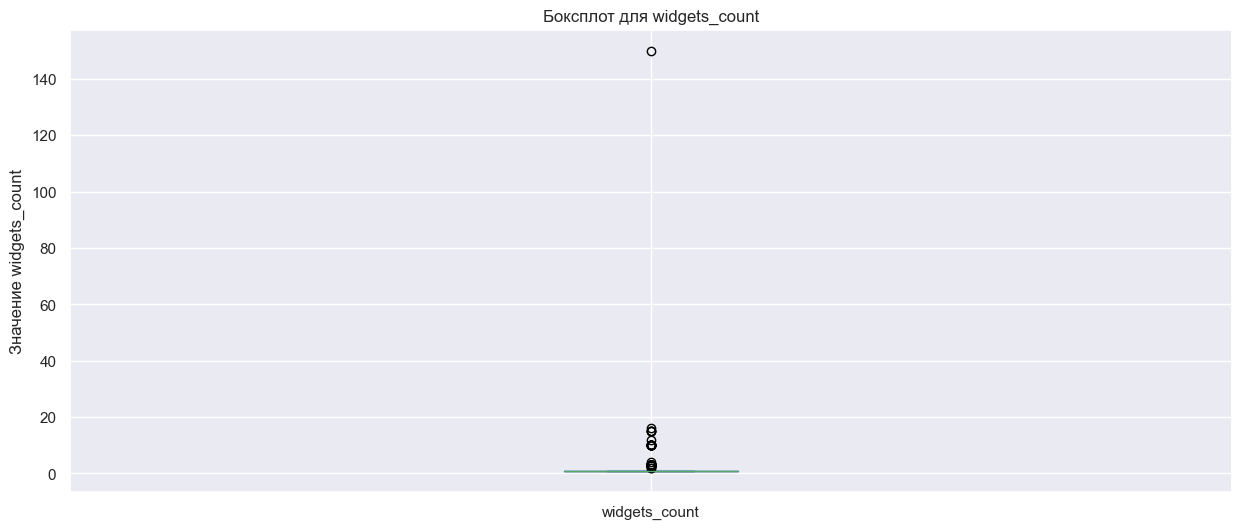

Базовая статистика для widgets_count:
count    5395.000000
mean        1.134940
std         2.200455
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       150.000000
Name: widgets_count, dtype: float64


In [41]:
# построим боксплот для единственного числового столбца widgets_count
users['widgets_count'].plot(kind='box')
plt.title('Боксплот для widgets_count')
plt.ylabel('Значение widgets_count')
plt.show()

#  Вывод базовой статистики
print("Базовая статистика для widgets_count:")
print(users['widgets_count'].describe())

**Распределение данных:**
- медиана, 25% и 75% квартель равны 1;
- межквартальный размах равен 0, этот значит, что все данные сконцентрированы вокруг значения 1;
- на боксплоте видны выбросы расположенные выше основной массы данных. это значит, что есть пользователи с большим количесивом виджетов (до 150)
- наличие выбросов может быть связано с тарифными планами, поэтому сгруппируем данные по тарифному плану и построим боксплоты для каждого тарифного плана.

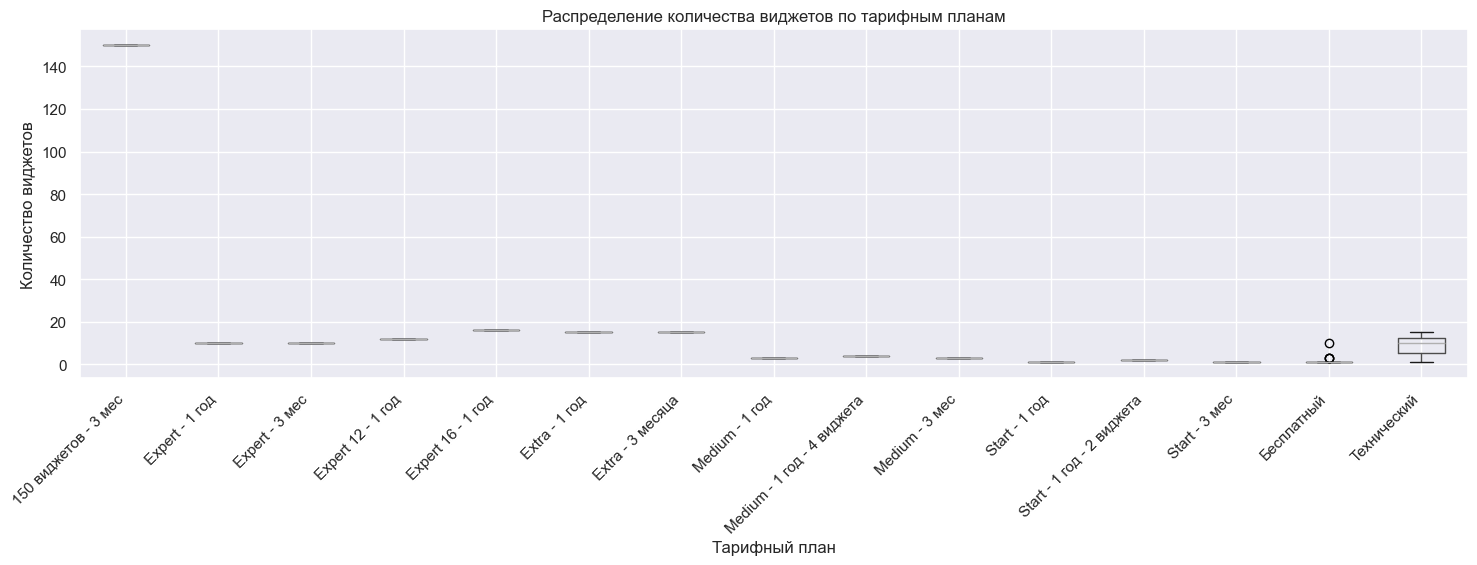


Базовая статистика для widgets_count по тарифным планам:
                             count        mean       std    min    25%    50%  \
plan_name                                                                       
150 виджетов - 3 мес           1.0  150.000000       NaN  150.0  150.0  150.0   
Expert - 1 год                23.0   10.000000  0.000000   10.0   10.0   10.0   
Expert - 3 мес                 5.0   10.000000  0.000000   10.0   10.0   10.0   
Expert 12 - 1 год              1.0   12.000000       NaN   12.0   12.0   12.0   
Expert 16 - 1 год              1.0   16.000000       NaN   16.0   16.0   16.0   
Extra - 1 год                  2.0   15.000000  0.000000   15.0   15.0   15.0   
Extra - 3 месяца               1.0   15.000000       NaN   15.0   15.0   15.0   
Medium - 1 год                85.0    3.000000  0.000000    3.0    3.0    3.0   
Medium - 1 год - 4 виджета     1.0    4.000000       NaN    4.0    4.0    4.0   
Medium - 3 мес                23.0    3.000000  0.0

In [43]:
# Группируем данные по тарифному плану и строим боксплоты для каждого тарифного плана

users.boxplot(column='widgets_count', by='plan_name') 
plt.title('Распределение количества виджетов по тарифным планам')
plt.suptitle('')
plt.xlabel('Тарифный план')
plt.ylabel('Количество виджетов')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout() 
plt.show()

# Выводим базовую статистику для каждого тарифного плана
print("\nБазовая статистика для widgets_count по тарифным планам:")
print(users.groupby('plan_name')['widgets_count'].describe())


- 150 виджетов, скорее всего, является особенностью тарифного плана, а не выбросом.
- большинство значений в других тарифах лежат в диапазоне от 1 до 15, что говорит о том, что количество виджетов ограничено в большинстве тарифных планов;
- на основании анализа данных по столбцу `widgets_count`, значительных выбросов в датафрейме `users` не выявлено.

<a id="section-2-2"></a>
#### 2.2 Предобработка данных в датафрейме `plans`

**1. Приведем название столбца `widgetsCount` к snake_case**

In [47]:
plans = plans.rename(columns={"widgetsCount": "widgets_count"})

# Проверка результата
print("Обновлённое название:")
print(plans.columns.tolist())

Обновлённое название:
['plan_id', 'name', 'widgets_count', 'value_rub', 'months', 'custom', 'is_trial']


**2. Проверим на дубликаты**

In [49]:
# Общее количество полных дубликатов
total_duplicates = plans.duplicated().sum()
print(f'Общее количество полных дубликатов: {total_duplicates}')

Общее количество полных дубликатов: 0


<a id="section-2-3"></a>
#### 2.3 Предобработка данных в датафрейме `payments`

**1. Приведем название столбцов `createdAt` и `planName` к snake_case**

In [52]:
payments = payments.rename(columns={
    "createdAt": "created_at",
    "planName": "plan_name"
})

# Проверка результата
print("Обновлённые названия столбцов:")
print(payments.columns.tolist())

Обновлённые названия столбцов:
['payment_id', 'order_id', 'status', 'created_at', 'plan_id', 'plan_name', 'amount', 'months']


**2. Преобразуем данные к нужным типам**

In [54]:
payments["created_at"] = pd.to_datetime(payments["created_at"])

In [55]:
# проверим результат
print("\nОбновлённая структура данных:")
print(payments .info())

print("\nПервые 5 строк:")
display(payments.head())


Обновлённая структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797 entries, 0 to 3796
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   payment_id  3797 non-null   object             
 1   order_id    3797 non-null   object             
 2   status      3797 non-null   object             
 3   created_at  3797 non-null   datetime64[ns, UTC]
 4   plan_id     3797 non-null   object             
 5   plan_name   3797 non-null   object             
 6   amount      3797 non-null   int64              
 7   months      3797 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 237.4+ KB
None

Первые 5 строк:


payment_id                              order_id     status  \
0  60f7bb86a8f24781ffb9d8e9  48992013-af97-45eb-834f-5d7b4571ebc8  SUCCEEDED   
1  60fa6182c1b1be872389289e  c9b61037-6285-4243-858f-e2aa69436e61  CANCELLED   
2  61038d1ec1b1be89628fca48  82605ff3-d9a4-45fd-bd0a-bd4f13e176a6  CANCELLED   
3  61038d44c1b1be27258fca5c  723ff40a-a103-41c1-b5ed-bc8ceaf08af8  SUCCEEDED   
4  6104de8cc1b1be5ee990e181  901ea285-d70c-4d31-af9c-c62eb951fc4d  CANCELLED   

                        created_at                   plan_id      plan_name  \
0 2021-07-21 06:15:34.993000+00:00  60eac72290455cce1f7ec8a4  Start - 1 год   
1 2021-07-23 06:28:18.274000+00:00  60eac72290455cce1f7ec8a4  Start - 1 год   
2 2021-07-30 05:24:46.708000+00:00  60eac72290455cce1f7ec8a4  Start - 1 год   
3 2021-07-30 05:25:24.959000+00:00  60eac72290455cce1f7ec8a4  Start - 1 год   
4 2021-07-31 05:24:28.405000+00:00  60eac72290455cce1f7ec8a4  Start - 1 год   

   amount  months  
0    1788      12  
1    1788      12  
2    1788      12  
3    1788      12  
4    1788      12

**3. Проверим на дубликаты**

In [57]:
# проверим количество уникальных платежей: должно быть 3797 (если меньше значит есть дубли)
print("Уникальных платежей:", payments["payment_id"].nunique())  

Уникальных платежей: 3797


<a id="section-2-4"></a>
#### 2.4 Предобработка данных в датафрейме `widgets`

**1. Приведем название столбцов к snake_case**

In [60]:
# Создаем словарь для переименования
rename_dict = {
    'user': 'user_id',
    'ratingThreshold': 'rating_threshold',
    'totalRating': 'total_rating',
    'totalReviewAmount': 'total_review_amount',
    'createdAt': 'created_at',
    'updatedAt': 'updated_at',
    'customSettings': 'custom_settings',
    'customStyles': 'custom_styles',
    'hideEmptyReviews': 'hide_empty_reviews',
    'hideWatermark': 'hide_watermark',
    'lastAttemptedAt': 'last_attempted_at'
}

# Применяем переименование
widgets = widgets.rename(columns=rename_dict)

# Проверяем результат
print("Обновленные названия столбцов:")
print(widgets.columns.tolist())

Обновленные названия столбцов:
['widget_id', 'user_id', 'title', 'url', 'rating_threshold', 'total_rating', 'total_review_amount', 'created_at', 'updated_at', 'custom_settings', 'custom_styles', 'hide_empty_reviews', 'hide_watermark', 'last_attempted_at', 'reviewAmount_doubleGis', 'reviewAmount_yaMarket', 'reviewAmount_instagram', 'reviewAmount_vkontakte', 'reviewAmount_avito', 'reviewAmount_googleMap', 'reviewAmount_yaSprav', 'reviewStars_one', 'reviewStars_two', 'reviewStars_three', 'reviewStars_four', 'reviewStars_five', 'reviewStars_undefined']


**2. Обработка пропусков**

In [62]:
# посчитаем количество пропусков в процентах
missing_percent = (widgets.isnull().sum() / len(widgets)) * 100

# Фильтруем только колонки с пропусками
missing_percent = missing_percent[missing_percent > 0]

# Сортируем по убыванию
missing_percent = missing_percent.sort_values(ascending=False)

# Форматируем вывод
pd.options.display.float_format = '{:.2f}%'.format
print("Процент пропусков по столбцам:")
print(missing_percent)

Процент пропусков по столбцам:
last_attempted_at        100.00%
reviewStars_undefined     99.91%
custom_styles             80.30%
custom_settings           13.50%
reviewAmount_avito         1.29%
hide_empty_reviews         1.10%
reviewAmount_googleMap     0.64%
reviewAmount_yaSprav       0.23%
hide_watermark             0.05%
dtype: float64


***Столбцы для удаления с высоким процентом пропусков:**

- `last_attempted_at`: 100 % пропусков (полностью пустой);
- `reviewStars_undefined `: 99.91% пропусков - практически нет данных;
- `custom_styles `: 80.3% пропусков - критично высокий уровень.

---
***Столбцы для заполнения пропусков:***

- `custom_settings`: 13,5% пропусков заполняем JSON-объектами, так как это настройки;
- `reviewAmount_avito`, `reviewAmount_googleMap`, `reviewAmount_yaSprav` заполняем нулями: раз отзывов нет, значит считать их количество нулевым;
- `hide_empty_reviews`, `hide_watermark` - булевы поля, если в них значение не указано, то заполним эти поля по умолчанию False.

In [64]:
# Удаление столбцов
widgets = widgets.drop(columns=['last_attempted_at', 'reviewStars_undefined', 'custom_styles'])

# Заполнение пропусков
widgets['custom_settings'] = widgets['custom_settings'].fillna('{}')

widgets[['reviewAmount_avito', 'reviewAmount_googleMap', 'reviewAmount_yaSprav']] = \
    widgets[['reviewAmount_avito', 'reviewAmount_googleMap', 'reviewAmount_yaSprav']].fillna(0).astype(int)

widgets['hide_empty_reviews'] = widgets['hide_empty_reviews'].fillna(False)
widgets['hide_watermark'] = widgets['hide_watermark'].fillna(False)

In [65]:
# проверим результат
print("\nПроверка пропусков:")
print(widgets.isna().sum())


Проверка пропусков:
widget_id                 0
user_id                   0
title                     0
url                       0
rating_threshold          0
total_rating              0
total_review_amount       0
created_at                0
updated_at                0
custom_settings           0
hide_empty_reviews        0
hide_watermark            0
reviewAmount_doubleGis    0
reviewAmount_yaMarket     0
reviewAmount_instagram    0
reviewAmount_vkontakte    0
reviewAmount_avito        0
reviewAmount_googleMap    0
reviewAmount_yaSprav      0
reviewStars_one           0
reviewStars_two           0
reviewStars_three         0
reviewStars_four          0
reviewStars_five          0
dtype: int64


**3. Преобразуем данные к нужным типам**

In [67]:
widgets[['created_at', 'updated_at']] = widgets[['created_at', 'updated_at']].apply(pd.to_datetime)
widgets[['hide_empty_reviews', 'hide_watermark']] = widgets[['hide_empty_reviews', 'hide_watermark']].fillna(False).astype(bool)

In [68]:
# проверим результат
print("\nОбновлённая структура данных:")
print(widgets.info())

print("\nПервые 5 строк:")
display(widgets.head())


Обновлённая структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   widget_id               2178 non-null   object             
 1   user_id                 2178 non-null   object             
 2   title                   2178 non-null   object             
 3   url                     2178 non-null   object             
 4   rating_threshold        2178 non-null   int64              
 5   total_rating            2178 non-null   float64            
 6   total_review_amount     2178 non-null   int64              
 7   created_at              2178 non-null   datetime64[ns, UTC]
 8   updated_at              2178 non-null   datetime64[ns, UTC]
 9   custom_settings         2178 non-null   object             
 10  hide_empty_reviews      2178 non-null   bool               
 11  hide_waterma

widget_id                   user_id                   title  \
0  5fa5093b68e72c750c4612a8  5f885185b4be871ce53efdfa               Barcodium   
1  5fa512294f39b07746bf990b  5f885185b4be871ce53efdfa       Babyshusher (old)   
2  5fdb603f286ed53ee8c37b7b  5f885185b4be871ce53efdfa                     BS2   
3  60548a6ddcb4200f71991e19  60548946dcb4200f71991e18         Amadey-print.ru   
4  60702b53dcb4200f71991e35  6030ee64dcb4200f71991e04  Отзывы приемка квартир   

                                url  rating_threshold  total_rating  \
0              https://barcodium.ru                 4         4.80%   
1           https://baby-shusher.ru                 0         4.80%   
2           https://baby-shusher.ru                 3         4.80%   
3      https://www.amadey-print.ru/                 0         5.00%   
4  https://inside-remont.ru/priemka                 4         5.00%   

   total_review_amount                created_at  \
0                   30 2020-11-06 08:28:43+00:00   
1                  200 2020-11-06 09:06:49+00:00   
2                   49 2020-12-17 13:42:23+00:00   
3                  299 2021-03-19 11:26:37+00:00   
4                   71 2021-04-09 10:24:19+00:00   

                        updated_at  \
0 2025-02-10 05:00:33.087000+00:00   
1 2025-02-10 00:08:13.668000+00:00   
2 2025-02-10 19:01:04.111000+00:00   
3 2025-02-08 04:01:04.999000+00:00   
4 2025-02-10 15:01:35.762000+00:00   

                                     custom_settings  ...  \
0  {"isShowUserName":true,"isShowUserImage":true,...  ...   
1  {"isShowUserName":true,"isShowUserImage":true,...  ...   
2  {"isShowUserName":true,"isShowUserImage":true,...  ...   
3  {"isShowUserName":true,"isShowUserImage":true,...  ...   
4  {"isShowUserName":true,"isShowUserImage":true,...  ...   

   reviewAmount_instagram  reviewAmount_vkontakte  reviewAmount_avito  \
0                       0                       0                   0   
1                       0                      14                  14   
2                       0                       0                  11   
3                       0                       0                   0   
4                       0                      30                   0   

   reviewAmount_googleMap  reviewAmount_yaSprav  reviewStars_one  \
0                       1                    29                3   
1                     110                    29                6   
2                       0                    38                2   
3                      49                   250                0   
4                       0                    41                5   

   reviewStars_two  reviewStars_three  reviewStars_four  reviewStars_five  
0                0                  0                 0                30  
1                1                  0                 3               199  
2                0                  2                 5                44  
3                0                  0                 2               202  
4                0                  1                 0                76  

[5 rows x 24 columns]

**4. Проверим на дубликаты**

In [70]:
# Общее количество полных дубликатов
total_duplicates = widgets.duplicated().sum()
print(f'Общее количество полных дубликатов: {total_duplicates}')

Общее количество полных дубликатов: 0


In [71]:
# проверими данные на неявные дубликаты по столбцу user_id
userid_duplicates = widgets['user_id'].duplicated().sum()
print(f'Дубликатов user_id: {userid_duplicates}')

Дубликатов user_id: 331


**Возможно 331 дубликат user_id - означает, что некоторые пользователи создали несколько виджетов. Сгруппируем пользователей с дубликатами для анализа.**

In [73]:
# Получаем пользователей с несколькими виджетами
users_with_multiple_widgets = widgets[widgets['user_id'].duplicated(keep=False)]

# Группируем по user_id для анализа
widgets_per_user = users_with_multiple_widgets.groupby('user_id').agg({'widget_id': 'count'}).sort_values(('widget_id'), ascending=False)

widgets_per_user.rename(columns={'widget_id': 'widget_count'}, inplace=True)

print(f"\nПользователи с несколькими виджетами (топ-5):")
display(widgets_per_user.head())


Пользователи с несколькими виджетами (топ-5):


widget_count
user_id                               
629771d26daca03f77859e34            73
62a22eb3381b1e4456ddbe85            16
63a9475e2ba494a0660bb8d5            15
656ef8a81123d79d90d8103c            14
65f944cc3f8b91eec46602d9            12

**ТОП-5 пользователей создали от 12 до 73 виджетов. Скорее всего это не дубликаты, а нормальное использование. Проверим дубликаты по комбинации "user_id + widget_id" и посчитаем среднее и максимальное количество виджетов на пользователя.**

In [75]:
# Проверка по комбинации "user_id + widget_id"
combo_duplicates = widgets.duplicated(subset=['user_id', 'widget_id']).sum()
print(f'\nДубликатов по комбинации user_id + widget_id: {combo_duplicates}')


Дубликатов по комбинации user_id + widget_id: 0


In [76]:
print(f"Среднее количество виджетов на пользователя: {widgets['user_id'].value_counts().mean():.1f}")
print(f"Максимальное количество: {widgets['user_id'].value_counts().max()}")

Среднее количество виджетов на пользователя: 1.2
Максимальное количество: 73


**5. Проверка на выбросы**

In [78]:
# Определяем столбцы для анализа на выбросы
rating_cols = ['total_rating', 'total_review_amount']

# Вычисляем базовую статистику для выбранных столбцов (среднее, стандартное отклонение, минимум, квартили, максимум)
stats = widgets[rating_cols].describe()

# Задаем формат отображения чисел с плавающей точкой (два знака после запятой)
pd.set_option('display.float_format', '{:.2f}'.format)

# Выводим статистику
print(stats)

       total_rating  total_review_amount
count       2178.00              2178.00
mean           4.26               331.23
std            1.53              1800.07
min            0.00                 0.00
25%            4.50                23.00
50%            4.80                79.00
75%            5.00               233.00
max            5.20             63462.00


**Основные метрики рейтингов и отзывов:**

- `total_rating` (средний рейтинг): 

   - среднее: 4.26;

   - минимум: 0.0;

   - максимум: 5.2 (некорректное значение, так как рейтинг обычно в диапазоне 1-5).

   - вывод: Есть аномалии (значения за пределами 1-5).

- `total_review_amount` (общее количество отзывов):

   - среднее: 331.23, но стандартное отклонение (1800.07) очень велико;

   - максимум: 63462 (сильный выброс);

   - 75% значений имеют ≤ 233 отзыва;

   - вывод: есть крайне аномальные значения (например, 63 тыс. отзывов).

In [80]:
# Создаем копию датафрейма, чтобы не изменять исходные данные
widgets_clean = widgets.copy()

#  Обработка аномальных рейтингов (total_rating < 1 или > 5)
print(f"Всего записей до обработки рейтингов: {len(widgets_clean)}")

# Найдем и удалим записи с некорректным рейтингом
invalid_rating_mask = (widgets_clean['total_rating'] < 1) | (widgets_clean['total_rating'] > 5)
invalid_rating_count = invalid_rating_mask.sum()

print(f"Найдено записей с аномальным рейтингом (<1 или >5): {invalid_rating_count}")
print("Примеры таких записей:")
display(widgets_clean[invalid_rating_mask][['widget_id', 'title', 'total_rating']].head())

# Удаляем эти записи
widgets_clean = widgets_clean[~invalid_rating_mask]
print(f"Осталось записей после удаления: {len(widgets_clean)}")

# Обработка выбросов в количестве отзывов (total_review_amount > 5000)
print("\nОбработка выбросов в количестве отзывов:")

# Найдем записи с аномально большим количеством отзывов
outlier_reviews_mask = widgets_clean['total_review_amount'] > 5000
outlier_reviews_count = outlier_reviews_mask.sum()

print(f"Найдено записей с >5000 отзывов: {outlier_reviews_count}")
print("Топ-5 таких записей:")
display(widgets_clean[outlier_reviews_mask][['widget_id', 'title', 'total_review_amount']].sort_values('total_review_amount', ascending=False).head())

# Удалить выбросы
widgets_clean = widgets_clean[~outlier_reviews_mask]

print(f"Осталось записей после обработки: {len(widgets_clean)}")

# Проверка статистик после очистки
print("\nОбновленные статистики:")
print(widgets_clean[['total_rating', 'total_review_amount']].describe())

Всего записей до обработки рейтингов: 2178
Найдено записей с аномальным рейтингом (<1 или >5): 240
Примеры таких записей:


widget_id              title  total_rating
96   625fbed3b1f835cac9ab3e52     Виджет отзывов          0.00
170  62b48d08edaba8533d7f9c8c              апекс          0.00
339  63ee07809ecd463947939f92            TE Club          0.00
342  63f239689ecd46231ca658e0  ПОДЕЛАМ Челябинск          5.20
354  64017e809ecd4660f9eb59cf                 вк          0.00

Осталось записей после удаления: 1938

Обработка выбросов в количестве отзывов:
Найдено записей с >5000 отзывов: 21
Топ-5 таких записей:


widget_id                 title  total_review_amount
1225  66585116be97c16fa6c31d31                 ya.ru                63462
2123  6798d3c3c82d342e42ec25a3          Авито отзывы                34799
1328  667a69d3be97c116f9e71936                пппппп                24044
1180  664b1aafbe97c190794ec5b7           Отзывы Soon                12359
1299  66707dcfbe97c11ecf97c849  Невский проспект, 50                 9883

Осталось записей после обработки: 1917

Обновленные статистики:
       total_rating  total_review_amount
count       1917.00              1917.00
mean           4.78               241.76
std            0.33               452.27
min            1.00                 1.00
25%            4.70                37.00
50%            4.90                99.00
75%            5.00               250.00
max            5.00              4855.00


**Анализ рейтингов (total_rating):**

   - диапазон нормализован: все значения теперь в корректном диапазоне 1.0-5.0;
   - среднее значение: 4.78 (высокий средний рейтинг);
   - стандартное отклонение: 0.33 (очень низкое);
   - медиана (50%): 4.90;
   - более 50% записей имеют рейтинг ≥ 4.9.

---
**Анализ количества отзывов (total_review_amount):**

   - среднее: 241.76 (было 331.23)
   - стандартное отклонение: 452.27 (было 1800.07). Разброс уменьшился в 4 раза;
   - максимум: 4855 (было 63462);
   - медиана: 99.00 - 50% записей имеют ≤ 99 отзывов;
   - распределение: 25% записей: ≤37 отзывов, 75% записей: ≤250 отзывов;

---
**Вывод:**
   - данные теперь лучше отражают реальную картину.

In [82]:
# посмотрим статистику по количеству отзывов на разных платформах
review_cols = ['reviewAmount_' + x for x in ['doubleGis', 'yaMarket', 'instagram', 
                                           'vkontakte', 'avito', 'googleMap', 'yaSprav']]
widgets_clean[review_cols].describe()

reviewAmount_doubleGis  reviewAmount_yaMarket  reviewAmount_instagram  \
count                 1917.00                1917.00                 1917.00   
mean                    24.98                   0.00                    0.00   
std                    102.90                   0.00                    0.00   
min                      0.00                   0.00                    0.00   
25%                      0.00                   0.00                    0.00   
50%                      0.00                   0.00                    0.00   
75%                      0.00                   0.00                    0.00   
max                   1167.00                   0.00                    0.00   

       reviewAmount_vkontakte  reviewAmount_avito  reviewAmount_googleMap  \
count                 1917.00             1917.00                 1917.00   
mean                     9.15               18.70                   32.38   
std                     70.70               91.84                  146.45   
min                      0.00                0.00                    0.00   
25%                      0.00                0.00                    0.00   
50%                      0.00                0.00                    0.00   
75%                      0.00                0.00                   11.00   
max                   1764.00             1762.00                 2361.00   

       reviewAmount_yaSprav  
count               1917.00  
mean                 156.56  
std                  331.96  
min                    0.00  
25%                   14.00  
50%                   54.00  
75%                  160.00  
max                 4354.00

**Текущее распределение по платформам:**

***Активные платформы:***
   - `Яндекс.Справочник (yaSprav)`: среднее - 156.56, максимум - 4354, 75% перцентиль - 160. Является основным источником отзывов, но имеет большой разброс данных;

   - `Google Карты (googleMap)`: среднее - 32.38, максимум - 2361, 75% перцентиль - 11. Имеет низкую медиану (0);

   - `2ГИС (doubleGis)`: среднее - 24.98, максимум - 1167. 75% записей имеют 0 отзывов;

   - `Авито (avito)`: среднее - 18.70, максимум - 1762. Имеет высокий максимум при медиане равной нулю;

   - `ВКонтакте (vkontakte)`: среднее - 9.15, максимум - 1 764. 75% записей имеют 0 отзывов.

---
***Неактивные платформы:***

   - `Яндекс.Маркет (yaMarket)`: все нули;

   - `Instagram`: Все нули.

---
**Предлагаю сделать дополнительную очистку: удалить столбцы с нулевыми отзывами.**

In [84]:
# Удаляем столбцы с нулевыми отзывами (где все значения = 0)
zero_platforms = [col for col in review_cols if widgets_clean[col].sum() == 0]
widgets = widgets_clean.drop(columns=zero_platforms)

print(f"Удалены столбцы: {zero_platforms}")

Удалены столбцы: ['reviewAmount_yaMarket', 'reviewAmount_instagram']


In [85]:
# проверим результат
print("\nОбновлённая структура данных:")
print(widgets.info())


Обновлённая структура данных:
<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 0 to 2177
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   widget_id               1917 non-null   object             
 1   user_id                 1917 non-null   object             
 2   title                   1917 non-null   object             
 3   url                     1917 non-null   object             
 4   rating_threshold        1917 non-null   int64              
 5   total_rating            1917 non-null   float64            
 6   total_review_amount     1917 non-null   int64              
 7   created_at              1917 non-null   datetime64[ns, UTC]
 8   updated_at              1917 non-null   datetime64[ns, UTC]
 9   custom_settings         1917 non-null   object             
 10  hide_empty_reviews      1917 non-null   bool               
 11  hide_watermark   

**Выводы по 2 разделу:**

***Данные 4 датафреймов были подготовлены к дальнейшему исследованию:***

   - Датафрейм `users`:
     1. Привели название 8 столбцов к snake_case.
     2. Обработали пропуски в стобце `plan_is_trial`: заполнили пропуски False.
     3. Столбцы `created_at`, `updated_at`, `plan_finished_at`, `plan_purchase_date`, `plan_is_trial` привели к нужному типу. Удалили столбец `widgets` так как в нем содержались данные, которые представляют собой пустые строки [].
     4. Проверили датафрейм на дубликаты: явных и неявных дубликатов в `users` нет.
     5. Проверили датафрейм на выбросы: выбросов не обнаружили.

---
   - Датафрейм `plans`:
     1. Привели название столбца `widgetsCount` к snake_case.
     2. Проверили на дубликаты - дубликатов не обнаружили.

---
   - Датафрейм `payments`:
     1. Привели название столбцов `createdAt` и `planName` к snake_case.
     2. Столбец `created_at` привели к datetime.
     3. Выполнили проверку на дубликаты - дубликатов не обнаружили.

---
   - Датафрейм `widgets`:
     1. Привели названия 10 столбцов к стилю snake_case. Столбец `user` переименовали в `user_id`, так как он обозначает id пользователя.
     2. Обработали пропуски: удалили 3 столбца с критическим процентом пропусков (`last_attempted_at`, `reviewStars_undefined`, `custom_styles`), заполнили пропуски в 5 столбцах (`reviewAmount_avito`, `reviewAmount_googleMap`, `reviewAmount_yaSprav`, `hide_empty_reviews`, `hide_watermark`).
     3. 7 столбцов (`reviewAmount_avito`, `reviewAmount_googleMap`, `reviewAmount_yaSprav`,`created_at`, `updated_at`, `hide_empty_reviews`, `hide_watermark` привели к нужным типам.
     4. Выполнили проверку на дубликаты - дубликатов не обнаружили.
     5. Проверили датафрейм на выбросы: обработали выбросы в столбце `total_rating` (удалили записи с рейтингм ниже 1 и выше 5), в столбце `total_review_amount` (удалили записи с отзывами более 5000). Удалили столбцы `reviewAmount_yaMarket`, `reviewAmount_instagram` с нулевыми отзывами.

<a id="section-3"></a>
### 3 Исследовательский анализ данных

<a id="section-3-1"></a>
#### 3.1 Анализ пользователей и тарифов

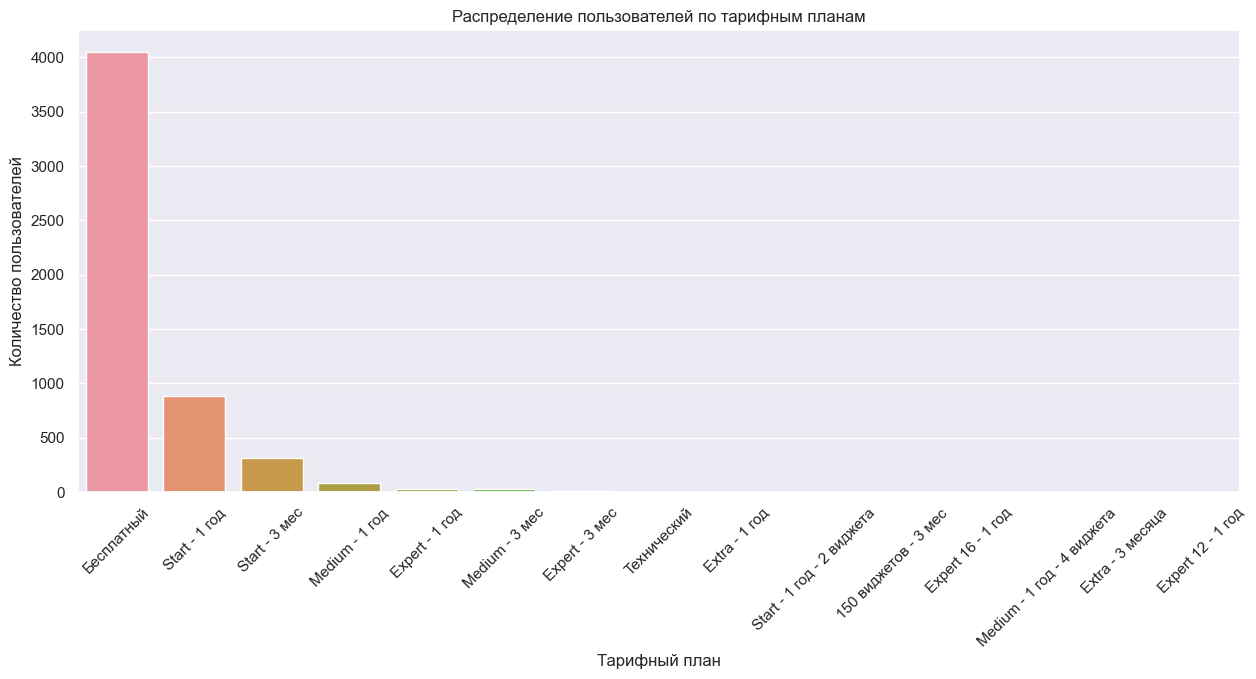

Доля активных подписок: 17.2%
Среднее количество виджетов по тарифам:


plan_name  widgets_count
0         150 виджетов - 3 мес         150.00
1            Expert 16 - 1 год          16.00
2                Extra - 1 год          15.00
3             Extra - 3 месяца          15.00
4            Expert 12 - 1 год          12.00
5               Expert - 1 год          10.00
6               Expert - 3 мес          10.00
7                  Технический           8.67
8   Medium - 1 год - 4 виджета           4.00
9               Medium - 1 год           3.00
10              Medium - 3 мес           3.00
11   Start - 1 год - 2 виджета           2.00
12                  Бесплатный           1.00
13               Start - 1 год           1.00
14               Start - 3 мес           1.00

In [89]:
# 1 Распределение пользователей по тарифам

sns.countplot(data=users, x='plan_name', order=users['plan_name'].value_counts().index)
plt.title('Распределение пользователей по тарифным планам')
plt.xlabel('Тарифный план')  
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

# Сравнение активных/неактивных подписок
active_ratio = users['plan_is_active'].value_counts(normalize=True)
print(f"Доля активных подписок: {active_ratio[True]:.1%}")

# Среднее количество виджетов на пользователя
avg_widgets = users.groupby('plan_name')['widgets_count'].mean().sort_values(ascending=False).reset_index()
print("Среднее количество виджетов по тарифам:")
display(avg_widgets)

- Наибольшее количество пользователей (более 4000) использует бесплатный тариф, что значительно превышает количество пользователей платных тарифов: Start 1 год (около 800) и Start 3 месяца (около 300).
- Доля активных подписок 17,2% - большинство клиентов не видят ценности в платных тарифаx.
- Популярные тарифы («Бесплатный», «Start») дают 1 виджет, а непопулярные («Expert», «150 виджетов») предлагают избыточные лимиты (10-150 виджетов), которые не востребованы.
- Среднее количество виджетов у платных пользователей: 1-3 (тарифы с лимитами >10 виджетов не учитываются).

<a id="section-3-2"></a>
#### 3.2 Анализ платежей (payments)

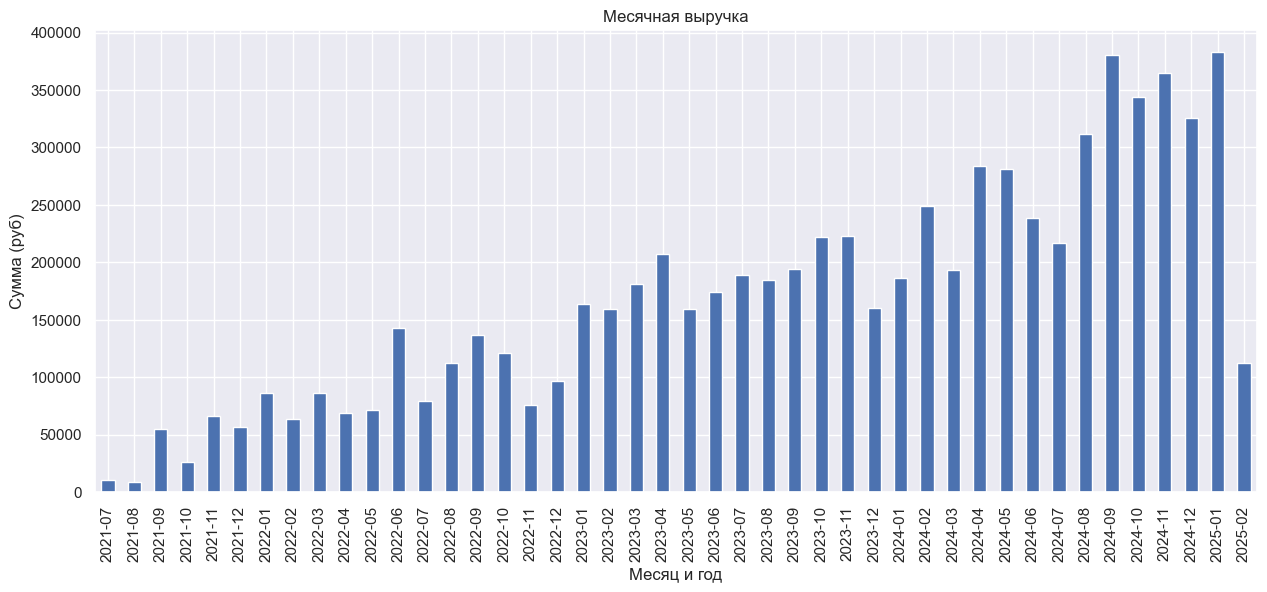

Средний чек по тарифам:


Тариф    Сумма
0                  150 виджетов - 3 мес 26000.00
1                   80 виджетов - 6 мес 23600.00
2                   80 виджетов - 3 мес 14400.00
3                     Expert 16 - 1 год 12800.00
4                         Extra - 1 год 12000.00
5                     Expert 15 - 1 год  9390.00
6           Expert 12 - 1 год (доплата)  8550.00
7                        Expert - 1 год  8098.42
8                        Medium - 1 год  4878.79
9             Start - 1 год - 2 виджета  4533.33
10           Medium - 1 год - 4 виджета  4375.00
11                     Extra - 3 месяца  4250.00
12              Extra - 1 год (доплата)  3120.00
13             Expert - 1 год (доплата)  2946.50
14                       Expert - 3 мес  2319.44
15             Medium - 1 год (доплата)  2274.33
16                        Start - 1 год  2210.24
17  Start - 1 год - 2 виджета (доплата)  2000.00
18                       Medium - 3 мес  1465.92
19                        Start - 3 мес   629.81
20             Expert - 1 месяц (аванс)     0.00

In [92]:
#  Динамика платежей по месяцам
payments['month_year'] = payments['created_at'].dt.tz_localize(None).dt.to_period('M')
monthly_revenue = payments.groupby('month_year')['amount'].sum()

monthly_revenue.plot(kind='bar')
plt.title('Месячная выручка')
plt.xlabel('Месяц и год') 
plt.ylabel('Сумма (руб)')
plt.show()

#  Средний чек по тарифам
avg_check = payments.groupby('plan_name')['amount'].mean().sort_values(ascending=False).reset_index()

# Переименовываем столбцы
avg_check.columns = ['Тариф', 'Сумма']

print("Средний чек по тарифам:")
display(avg_check)

- Наблюдается значительный рост месячной выручки: от минимальных значений в июле-августе 2021 года (около 10 000 руб.) до пиковых значений в период с сентября 2024 по январь 2025 года (300 000 - 370 000 руб.). Этот рост может быть связан с увеличением количества клиентов, изменением тарифной политики или другими факторами.
- Наибольший средний чек наблюдается по тарифам, предлагающим большое количество виджетов (от 80 до 150) — до 26 000 руб. Это может указывать на то, что пользователи, которым нужен широкий функционал, готовы платить больше. Тарифы, предлагающие 1-2 виджета, имеют значительно меньший средний чек (от 629 руб.), что отражает более низкую ценность для пользователей.
- Можно провести дополнительное исследование: сравнить динамику выручки с количеством новых пользователей. 

<a id="section-3-3"></a>
#### 3.3 Сравнение динамики выручки с количеством новых пользователей

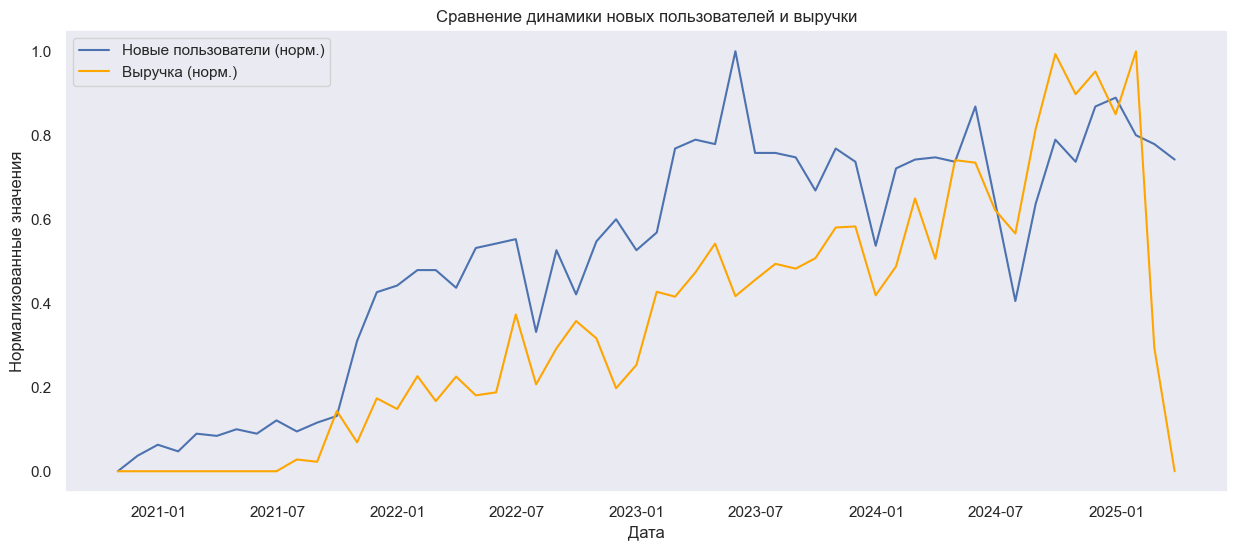

In [95]:
# Создаем временные ряды с одинаковым форматом дат
monthly_users = users.set_index('created_at').resample('M').agg({
    'user_id': 'count',
    'plan_is_trial': 'sum'
}).rename(columns={'user_id': 'new_users', 'plan_is_trial': 'trial_users'})

# Подготовка данных о выручке
monthly_rev = payments.set_index('created_at').resample('M')['amount'].sum()

# Объединяем данные
monthly_data = monthly_users.join(monthly_rev.rename('revenue'), how='outer').fillna(0)

# Нормализация 
normalized = monthly_data.copy()
normalized['new_users'] = ((monthly_data['new_users'] - monthly_data['new_users'].min()) / 
                         (monthly_data['new_users'].max() - monthly_data['new_users'].min()))
normalized['revenue'] = ((monthly_data['revenue'] - monthly_data['revenue'].min()) / 
                       (monthly_data['revenue'].max() - monthly_data['revenue'].min()))

# Визуализация
plt.plot(normalized.index, normalized['new_users'], label='Новые пользователи (норм.)')
plt.plot(normalized.index, normalized['revenue'], label='Выручка (норм.)', color='orange')
plt.title('Сравнение динамики новых пользователей и выручки')
plt.xlabel('Дата')
plt.ylabel('Нормализованные значения')
plt.legend()
plt.grid()
plt.show()

- Наблюдается общая синхронность между графиками динамики новых пользователей и выручки, что позволяет сделать вывод о том, что рост выручки в основном обусловлен притоком новых клиентов.
- Однако, стоит отметить некоторые расхождения в отдельные периоды, например, с конца 2022 по середину 2023 года, когда рост числа новых пользователей немного опережал рост выручки, а также в конце 2024 года, когда рост выручки был более выраженным, чем рост числа новых пользователей.
- Возможно в период с конца 2022 года количество триальных пользователей возросло, тогда это объяснит расхождение в графиках роста выручки и количества пользователей в этот период.
- Возможно прирост выручки был обоснован переходом существующих пользователей на более дорогие тарифы.

In [97]:
# проверим количество триальных пользователей
trial_users_monthly = users[users['plan_is_trial']].set_index('created_at').resample('M')['user_id'].count()

trial_users_period = trial_users_monthly.loc['2022-10':'2023-06'].reset_index()

display(trial_users_period)

created_at  user_id
0 2022-10-31 00:00:00+00:00       79
1 2022-11-30 00:00:00+00:00       97
2 2022-12-31 00:00:00+00:00       77
3 2023-01-31 00:00:00+00:00       79
4 2023-02-28 00:00:00+00:00      121
5 2023-03-31 00:00:00+00:00      115
6 2023-04-30 00:00:00+00:00      119
7 2023-05-31 00:00:00+00:00      148
8 2023-06-30 00:00:00+00:00      121

- Здесь мы видим резкий рост с февраля 2023 года пользователей, пользующимся бесплатным тарифом. Это и объясняет расхождение графиков роста числа новых пользователей и выручки в этот период.

***Посмотрим распределение платежей по тарифам за период октябрь - декабрь 2024 года. Сравним средний чек за период конца 2024 года и предыдущим периодом июль - сентябрь 2024 года***

In [100]:
# Фильтр данных за конец 2024
payments_2024 = payments[(payments['created_at'] >= '2024-10-01') & (payments['created_at'] <= '2024-12-31')]

# Распределение платежей по тарифам
print("\nРаспределение платежей по тарифам (октябрь-декабрь 2024):")
display(payments_2024['plan_name'].value_counts().reset_index())

# Сравнение с предыдущим периодом (июль-сентябрь 2024)
payments_prev = payments[(payments['created_at'] >= '2024-07-01') & (payments['created_at'] <= '2024-09-30')]

# Вычисление количества платежей  за период октябрь-декабрь 2024
count_2024 = len(payments_2024)

# Вычисление среднего чека и вывод
avg_current = payments_2024['amount'].mean()
avg_prev = payments_prev['amount'].mean()

print(f"\nСредний чек: {avg_prev:.0f} руб. (июль-сентябрь) -> {avg_current:.0f} руб. (октябрь-декабрь)")
print(f"Количество платежей за октябрь-декабрь 2024: {count_2024}")


Распределение платежей по тарифам (октябрь-декабрь 2024):


plan_name  count
0     Start - 1 год    275
1     Start - 3 мес    113
2    Medium - 1 год     29
3    Medium - 3 мес      9
4    Expert - 1 год      8
5    Expert - 3 мес      5
6  Extra - 3 месяца      1


Средний чек: 2214 руб. (июль-сентябрь) -> 2350 руб. (октябрь-декабрь)
Количество платежей за октябрь-декабрь 2024: 440


***Видим увеличение среднего чека с 2214 до 2350 руб. Посмотрим, на сколько процентов увеличились доля тарифов `Start - 1 год`в этот период.***

In [102]:
# Сравнение структуры платежей
prev_period = payments[(payments['created_at'] >= '2024-07-01') & (payments['created_at'] <= '2024-09-30')]
current_period = payments[(payments['created_at'] >= '2024-10-01') & (payments['created_at'] <= '2024-12-31')]

print("Доля тарифов Start - 1 год:")
print(f"- Июль-сентябрь: {prev_period['plan_name'].str.contains('Start - 1 год').mean():.1%}")
print(f"- Октябрь-декабрь: {current_period['plan_name'].str.contains('Start - 1 год').mean():.1%}")

Доля тарифов Start - 1 год:
- Июль-сентябрь: 53.9%
- Октябрь-декабрь: 62.5%


- Таким образом мы видим увеличение доли тарифа `Start - 1 год` с 53.9% до 62.5% (на 8.6 %).
- При общем количестве платежей 440 за октябрь-декабрь имеем дополнительные 38 платежей (440 × 0.086) по Start - 1 год
- Это и объясняет расхождения в графиках новых пользователей и выручки на конец 2024 года.

<a id="section-3-4"></a>
#### 3.4 Анализ виджетов (widgets)

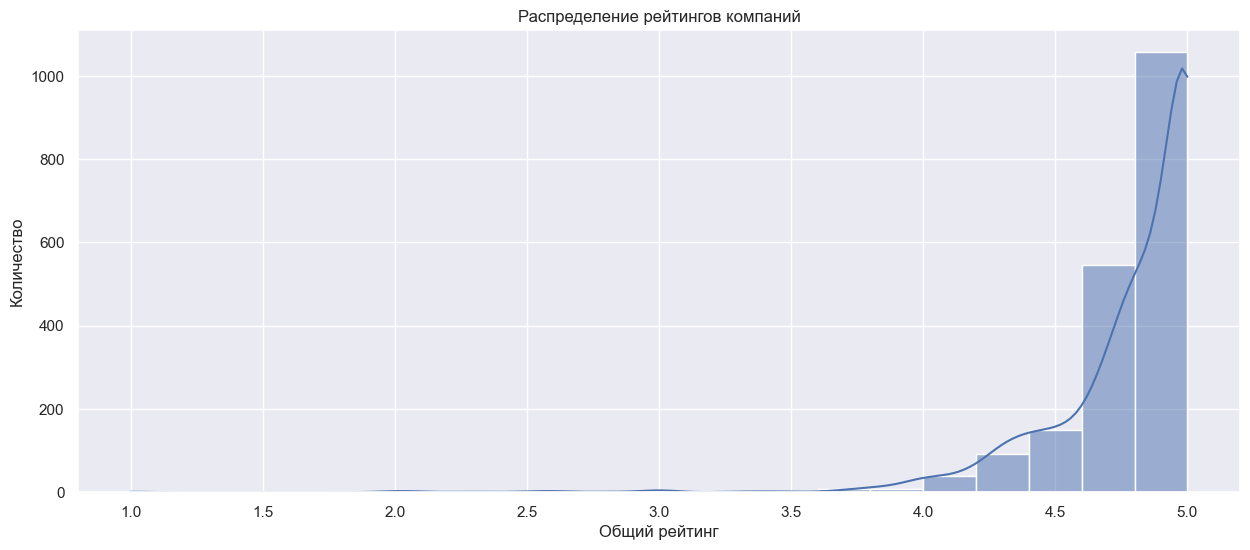

Платформа  Количество отзывов
0    reviewAmount_yaSprav              300129
1  reviewAmount_googleMap               62077
2  reviewAmount_doubleGis               47882
3      reviewAmount_avito               35842
4  reviewAmount_vkontakte               17533

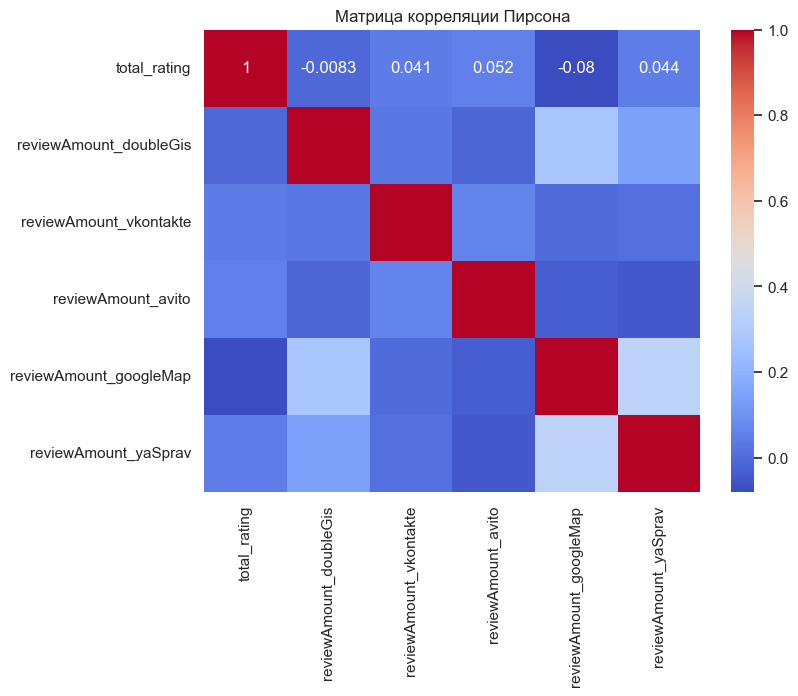

In [105]:
# Распределение рейтингов
sns.histplot(data=widgets, x='total_rating', bins=20, kde=True)
plt.title('Распределение рейтингов компаний')
plt.xlabel('Общий рейтинг')
plt.ylabel('Количество')
plt.show()

# Топ-5 платформ по количеству отзывов
platforms = ['doubleGis', 'vkontakte', 'avito', 'googleMap', 'yaSprav']
platform_stats = widgets[[f'reviewAmount_{p}' for p in platforms]].sum().sort_values(ascending=False).reset_index()
platform_stats.columns = ['Платформа', 'Количество отзывов']
#print("Общее количество отзывов по платформам:")
display(platform_stats)

# Корреляция между количеством отзывов и рейтингом
# Формируем список столбцов для анализа
platforms = ['doubleGis', 'vkontakte', 'avito', 'googleMap', 'yaSprav']
columns_for_analysis = ['total_rating'] + [f'reviewAmount_{p}' for p in platforms]

# Выбираем только нужные столбцы из DataFrame
widgets_subset = widgets[columns_for_analysis]

# Вычисляем матрицу корреляции Пирсона
corr_matrix = widgets_subset.corr(method='pearson')

# Визуализируем матрицу корреляции
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Пирсона')
plt.show()

In [106]:
print("Матрица корреляции (Пирсон):")
display(corr_matrix.round(2))

Матрица корреляции (Пирсон):


total_rating  reviewAmount_doubleGis  \
total_rating                    1.00                   -0.01   
reviewAmount_doubleGis         -0.01                    1.00   
reviewAmount_vkontakte          0.04                    0.03   
reviewAmount_avito              0.05                   -0.01   
reviewAmount_googleMap         -0.08                    0.28   
reviewAmount_yaSprav            0.04                    0.14   

                        reviewAmount_vkontakte  reviewAmount_avito  \
total_rating                              0.04                0.05   
reviewAmount_doubleGis                    0.03               -0.01   
reviewAmount_vkontakte                    1.00                0.06   
reviewAmount_avito                        0.06                1.00   
reviewAmount_googleMap                   -0.00               -0.04   
reviewAmount_yaSprav                      0.01               -0.05   

                        reviewAmount_googleMap  reviewAmount_yaSprav  
total_rating                             -0.08                  0.04  
reviewAmount_doubleGis                    0.28                  0.14  
reviewAmount_vkontakte                   -0.00                  0.01  
reviewAmount_avito                       -0.04                 -0.05  
reviewAmount_googleMap                    1.00                  0.34  
reviewAmount_yaSprav                      0.34                  1.00

-  Распределение рейтинга компаний неравномерно, с большим скоплением компаний, имеющих рейтинг, близкий к 5. Это указывает на то, что большинство компаний имеют хорошие или отличные оценки. Однако, на графике присутствует заметный "хвост" компаний с низкими рейтингами, что говорит о существовании компаний с плохим сервисом или продуктом. 
- Абсолютный лидер — Яндекс.Справочник (300 тыс. отзывов). Это говорит о том, что платформа либо популярна среди пользователей, либо компании активнее всего используют её для сбора оценок.
- Рейтинг (`total_rating`) практически не зависит от количества отзывов на любой из платформ: 
Все коэффициенты близки к нулю (от -0.08 до 0.05 
- Наблюдается слабая связь среди платформ 
Google Карты и Яндекс.Справочник (0.34) — компании, собирающие отзывы в Google, чаще используют и Яндекс.
- 2ГИС и Google Карты (0.28 слабая связь, возможно, из-за схожего аудиторного охвата.).

<a id="section-3-5"></a>
#### 3.5 Анализ активности и удовлетворённости клиентов по тарифам

plan_name                   user_id  widget_id
0   150 виджетов - 3 мес  629771d26daca03f77859e34         73
30     Expert 16 - 1 год  62a22eb3381b1e4456ddbe85         16
32         Extra - 1 год  63a9475e2ba494a0660bb8d5         15
29     Expert 12 - 1 год  65f944cc3f8b91eec46602d9         12
7         Expert - 1 год  63174e4b4e24da384da23cea         10

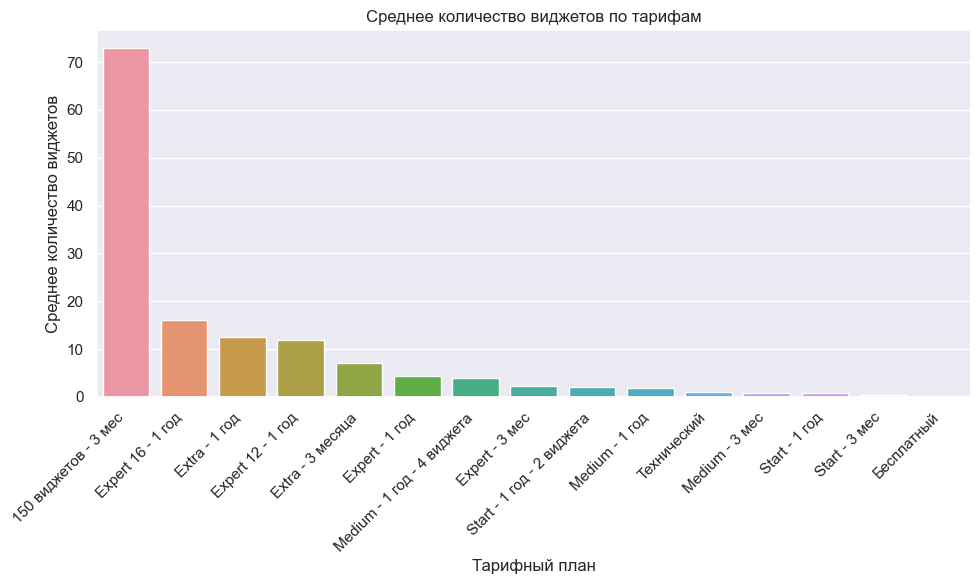

Средний рейтинг компаний по тарифам:


Тариф  Общий рейтинг
0                  Технический           4.97
1               Medium - 3 мес           4.95
2               Expert - 3 мес           4.88
3               Medium - 1 год           4.87
4                Start - 1 год           4.85
5                Start - 3 мес           4.83
6   Medium - 1 год - 4 виджета           4.75
7                   Бесплатный           4.73
8               Expert - 1 год           4.73
9                Extra - 1 год           4.72
10           Expert 16 - 1 год           4.58
11           Expert 12 - 1 год           4.51
12   Start - 1 год - 2 виджета           4.50
13        150 виджетов - 3 мес           4.46
14            Extra - 3 месяца           4.39

In [109]:
#  Количество виджетов на пользователя и тариф
merged_data = users.merge(widgets, on='user_id', how='left')
widgets_per_user = merged_data.groupby(['plan_name', 'user_id'])['widget_id'].count().reset_index()
widgets_per_user = widgets_per_user.sort_values(by = 'widget_id',  ascending=False)
display(widgets_per_user.head())

avg_widgets = widgets_per_user.groupby('plan_name')['widget_id'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.barplot(x='plan_name', y='widget_id', data=avg_widgets)
plt.title('Среднее количество виджетов по тарифам')
plt.xlabel('Тарифный план')
plt.ylabel('Среднее количество виджетов')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


#  Средний рейтинг компаний по тарифам
avg_rating_by_plan = merged_data.groupby('plan_name')['total_rating'].mean().sort_values(ascending=False).reset_index()

# Переименовываем столбцы
avg_rating_by_plan.columns = ['Тариф', 'Общий рейтинг']

print("Средний рейтинг компаний по тарифам:")
display(avg_rating_by_plan)

- Чем больше виджетов разрешает тариф - тем активнее клиенты их используют. Например, те, кто взял тариф на 150 виджетов, реально подключают десятки виджетов. Значит, когда бизнесу нужно много виджетов - они готовы платить за такие тарифы.
- Платные клиенты ставят более высокие оценки (4.5-4.9 из 5), чем бесплатные (4.7). Особенно довольны те, кто выбрал короткие платные тарифы - Medium - 3 мес (4.95), Expert на 3 месяца (4.88) и Start на год (4.85). Видимо, когда люди платят - они серьезнее относятся к работе с отзывами.
- Самый высокий рейтинг у Технического тарифа, но он видимо тестовый, поэтому не учитываем его в анализе.
- Любопытно, что самые дорогие тарифы (типа 150 виджетов) получают оценки чуть ниже (4.46), чем более простые платные тарифы. Возможно, крупные компании оценивают строже, либо у них больше отзывов и средняя оценка получается более сглаженной.

<a id="section-3-6"></a>
#### 3.6 Анализ эффективности тарифов: LTV, конверсия и выбор после триала

**Рассчитаем LTV  по тарифам: LTV = (Средний доход с пользователя) × (Среднее время жизни в днях / 30)**

- Поскольку в таблице `payments` отсутствует user_id, но есть информация о планах (plan_name) и датах платежей (created_at), используется композитный ключ для соединения данных. Этот ключ создается путем объединения названия тарифа (plan_name) и даты покупки/платежа (приведенной к строковому формату без времени)
- Данный расчёт LTV является приблизительным, так как соединение таблиц выполняется по композитному ключу (plan_name + дата), а не по точному соответствию user_id. Это может приводить к неточностям и ложным сопоставлениям.

Финальный расчет LTV по тарифам:


avg_ltv  median_ltv  users_count
plan_name                                                    
150 виджетов - 3 мес       593666.67   593666.67            1
Expert 16 - 1 год          361813.33   361813.33            1
Extra - 1 год              334400.00   334400.00            1
Expert - 1 год             304914.75   252386.67           20
Medium - 1 год - 4 виджета 269280.00   269280.00            1
Start - 1 год              205241.41   136485.00          762
Medium - 1 год             182159.10   139100.00           72
Start - 1 год - 2 виджета  109920.00   109920.00            2
Extra - 3 месяца            63891.67    63891.67            1
Medium - 3 мес              28133.27    13527.00           23
Start - 3 мес               17636.39     8580.00          251
Expert - 3 мес              13702.80    15010.00            3


Детализация по пользователям:
Всего пользователей с платежами: 1138
Средний LTV по всем тарифам: 160427 руб.
Медианный LTV: 95326 руб.


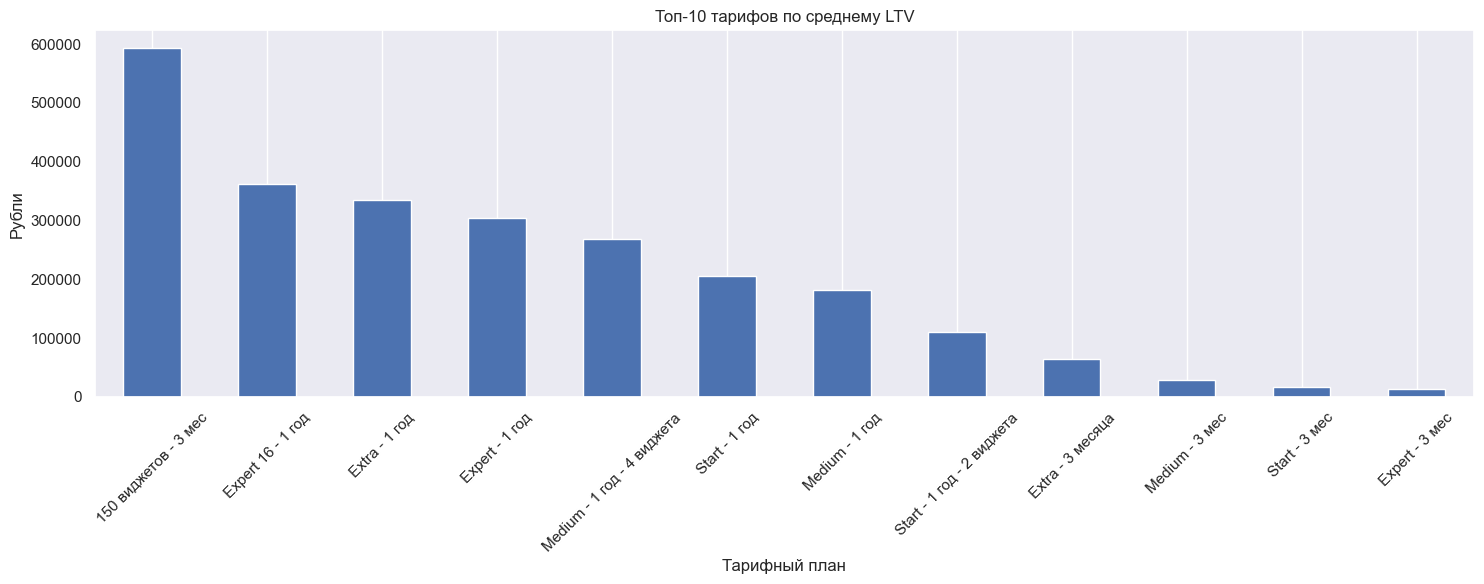

In [114]:
# Добавляем lifetime_days в users (только для завершенных подписок)
users['lifetime_days'] = (users['plan_finished_at'] - users['created_at']).dt.days

# Соединение таблиц 
users['purchase_day'] = users['plan_purchase_date'].dt.date.astype(str)
payments['payment_day'] = payments['created_at'].dt.date.astype(str)
users['composite_key'] = users['plan_name'] + '_' + users['purchase_day']
payments['composite_key'] = payments['plan_name'] + '_' + payments['payment_day']

user_payments = payments.merge(
    users[['user_id', 'composite_key', 'lifetime_days']],
    on='composite_key',
    how='left'
)

valid_payments = user_payments.dropna(subset=['user_id'])

# Расчет LTV
# Группируем по user_id и plan_name (на случай нескольких платежей)
ltv_calc = valid_payments.groupby(['user_id', 'plan_name']).agg(
    total_revenue=('amount', 'sum'),
    lifetime_days=('lifetime_days', 'max')
).reset_index()

# Рассчитываем LTV в рублях (переводим дни в месяцы)
ltv_calc['ltv_rub'] = ltv_calc['total_revenue'] * (ltv_calc['lifetime_days'] / 30)

# Агрегация по тарифам
ltv_by_plan = ltv_calc.groupby('plan_name').agg(
    avg_ltv=('ltv_rub', 'mean'),
    median_ltv=('ltv_rub', 'median'),
    users_count=('user_id', 'nunique')
).sort_values('avg_ltv', ascending=False)

# Вывод результатов
print("="*50)
print("Финальный расчет LTV по тарифам:")
display(ltv_by_plan.head(12))

print("\n" + "="*50)
print("Детализация по пользователям:")
print(f"Всего пользователей с платежами: {ltv_calc['user_id'].nunique()}")
print(f"Средний LTV по всем тарифам: {ltv_calc['ltv_rub'].mean():.0f} руб.")
print(f"Медианный LTV: {ltv_calc['ltv_rub'].median():.0f} руб.")

# Визуализация
ltv_by_plan['avg_ltv'].head(12).plot(kind='bar')
plt.title('Топ-10 тарифов по среднему LTV')
plt.xlabel('Тарифный план')
plt.ylabel('Рубли')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Сохранение результатов
#ltv_calc.to_csv('user_ltv_calculations.csv', index=False)
#ltv_by_plan.to_csv('ltv_by_plan.csv')

**Выводы и наблюдения:**
- Тарифы `150 виджетов - 3 мес` (593тыс. руб.) и `Expert 16 - 1 год` (361тыс. руб.) имеют аномально высокий LTV при минимальном количестве пользователей (users_count=1). Вероятно, единичные корпоративные клиенты с особыми условиями или ошибки в данных.
- Основные тарифы: `Start - 1 год`- cредний LTV 205тыс. руб. (медиана 136тыс.) для 762 пользователей и `Medium - 1 год`- LTV 182тыс. руб. (медиана 139тыс) для 72 пользователей.
- Существует разрыв между медианным и средним значением, например для тарифа `Expert - 1 год` 304тыс. против 252тыс. рублей. Возможно несколько клиентов платят значительно больше основной массы.
- Лучше ориентироваться на медианные значения LTV это поможет лучше отразить типичного пользователя.

**Рассчитаем конверсию из триальных пользователей в платные**

In [117]:
# Исключаем технический тариф
users_non_technical = users[users['plan_name'] != 'Технический']

# Отделяем бесплатных пользователей
free_users = users_non_technical[users_non_technical['plan_name'] == 'Бесплатный']

# Платные пользователи (все, кроме бесплатного и технического)
paid_users = users_non_technical[users_non_technical['plan_name'] != 'Бесплатный']

In [118]:
#Общая конверсия в платные тарифы
total_free = len(free_users)
total_paid = len(paid_users)
conversion_rate = total_paid / (total_free + total_paid) * 100

print(f"Бесплатных пользователей: {total_free}")
print(f"Платных пользователей: {total_paid}")
print(f"Общая конверсия в платные тарифы: {conversion_rate:.2f}%")

Бесплатных пользователей: 4048
Платных пользователей: 1344
Общая конверсия в платные тарифы: 24.93%


In [119]:
# Пользователи, которые были в триале и стали платными
trial_converted = paid_users[paid_users['plan_is_trial'] == True]
trial_conversion_rate = len(trial_converted) / len(paid_users) * 100

print(f"\nИз платных пользователей перешли из триала: {len(trial_converted)}")
print(f"Доля платных пользователей, которые когда-то были в триале: {trial_conversion_rate:.2f}%")


Из платных пользователей перешли из триала: 3
Доля платных пользователей, которые когда-то были в триале: 0.22%


In [120]:
# Все пользователи, у которых был триал (бесплатные или платные)
all_trial_users = users_non_technical[users_non_technical['plan_is_trial'] == True]

# Из них те, кто стал платным
trial_converted = all_trial_users[all_trial_users['plan_name'] != 'Бесплатный']

# Конверсия из триала в платные
true_trial_conversion_rate = len(trial_converted) / len(all_trial_users) * 100

print(f"Всего пользователей с триалом: {len(all_trial_users)}")
print(f"Из них перешли на платный тариф: {len(trial_converted)}")
print(f"Конверсия из триала в платные: {true_trial_conversion_rate:.2f}%")

Всего пользователей с триалом: 3749
Из них перешли на платный тариф: 3
Конверсия из триала в платные: 0.08%


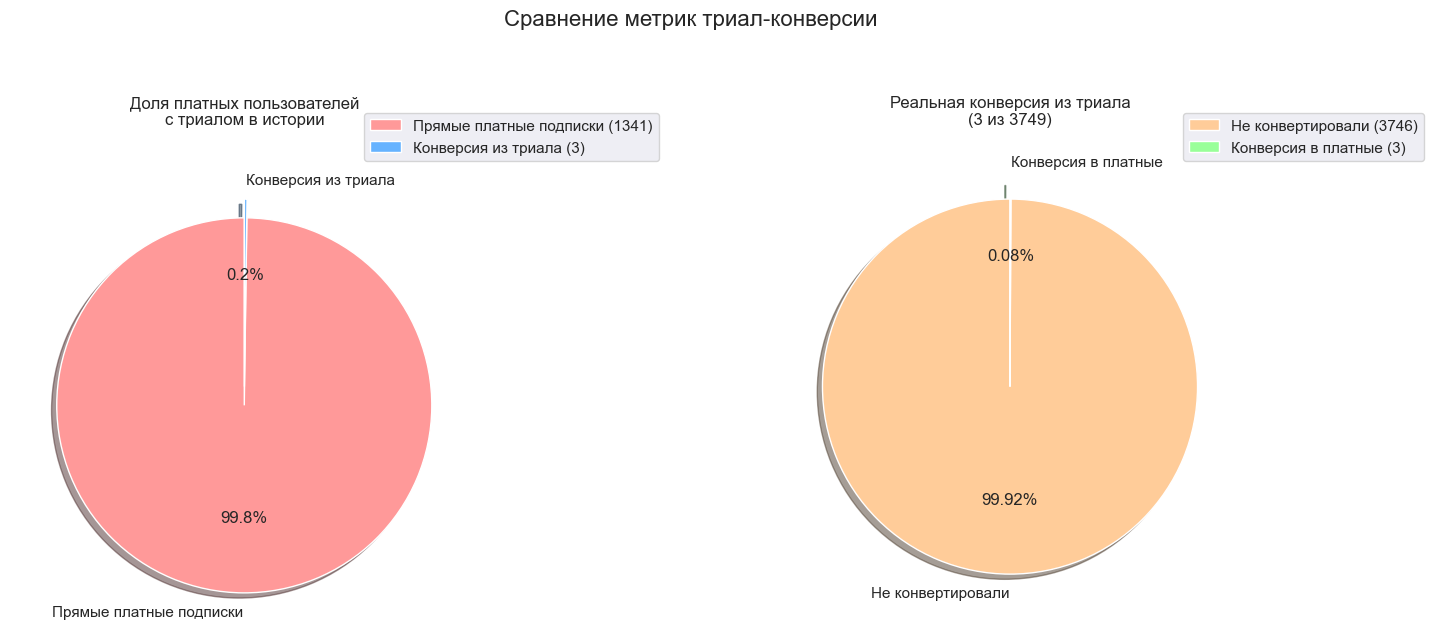

In [121]:
# Данные для первой визуализации (текущая метрика)
labels1 = ['Прямые платные подписки', 'Конверсия из триала']
sizes1 = [len(paid_users) - len(trial_converted), len(trial_converted)]
colors1 = ['#ff9999','#66b3ff']

# Данные для второй визуализации (реальная конверсия)
labels2 = ['Не конвертировали', 'Конверсия в платные']
sizes2 = [len(all_trial_users) - len(trial_converted), len(trial_converted)]
colors2 = ['#ffcc99','#99ff99']

# Создаем сетку графиков
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Первая диаграмма (доля платных пользователей с триалом в истории)
ax1.pie(sizes1, 
        explode=(0.1, 0), 
        labels=labels1, 
        colors=colors1,
        autopct='%1.1f%%',
        shadow=True,
        startangle=90)
ax1.set_title('Доля платных пользователей\nс триалом в истории', pad=20)

# Вторая диаграмма (реальная конверсия)
ax2.pie(sizes2,
        explode=(0, 0.1),
        labels=labels2,
        colors=colors2,
        autopct=lambda p: f'{p:.2f}%' if p > 0 else '',
        shadow=True,
        startangle=90)
ax2.set_title(f'Реальная конверсия из триала\n({len(trial_converted)} из {len(all_trial_users)})', pad=20)

# Общий заголовок
fig.suptitle('Сравнение метрик триал-конверсии', fontsize=16, y=1.05)

# Легенда с абсолютными значениями
for ax, sizes in zip([ax1, ax2], [sizes1, sizes2]):
    ax.legend(
        [f'{label} ({value})' for label, value in zip(ax.get_legend_handles_labels()[1], sizes)],
        loc='upper right',
        bbox_to_anchor=(1.4, 1.10)
    )

plt.tight_layout()
plt.show()

- Доля платных пользователей составляет около 25%, это может говорить о низкой монетизации продукта.
- Очень низкая доля платных пользователей с триалом в истории (0,22%).
- Крайне низкая общая конверсия (0,08 %). Т.е. из 1000 пользователей только один переходит на платный тариф. Это означает, что триальная версия продукта крайне неэффективна в привлечении новых платных пользователей
- Все это может говорить либо об ошибках в учетах триалов, либо о неэффективности триальной модели, либо триалом пользуются пользователи, не заинтересованные в дальнейшем использовании продукта.

<a id="section-3-7"></a>
#### 3.7 Анализ оттока пользователей (Churn Analysis)

***Определим, через какое время пользователи перестают быть активными (переходят на бесплатный тариф или перестают продлевать подписку).***

In [125]:
# Расчет среднего времени жизни пользователя
active_users = users[users['plan_is_active']]
churned_users = users[~users['plan_is_active']].copy()

# Время от создания до прекращения подписки
churned_users['lifetime'] = (churned_users['plan_finished_at'] - churned_users['created_at']).dt.days
print(f"Среднее время жизни отточных пользователей: {churned_users['lifetime'].mean():.0f} дней")

Среднее время жизни отточных пользователей: 59 дней


***Построим кривую выживаемости (survival analysis) для разных тарифов.***

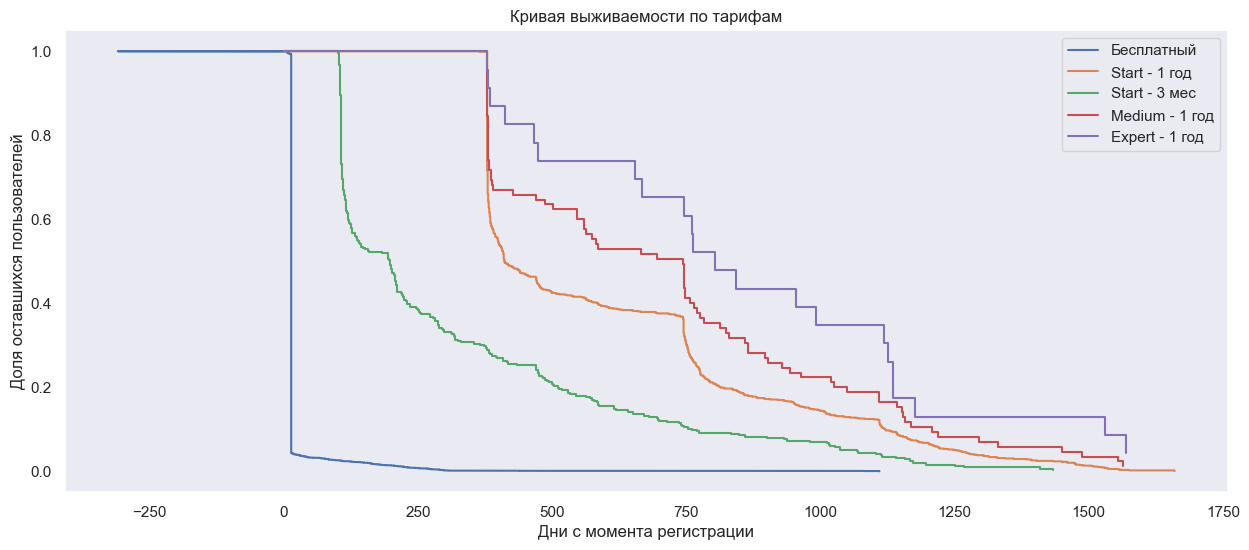

In [127]:
# Подготовка данных
users['lifetime_days'] = (users['plan_finished_at'] - users['created_at']).dt.days
users['churned'] = ~users['plan_is_active']  # True если пользователь ушел

# Выбираем топ-5 тарифов для анализа
top_plans = users['plan_name'].value_counts().index[:5]


for plan in top_plans:
    # Фильтруем пользователей по тарифу
    plan_users = users[users['plan_name'] == plan].copy()
    
    # Сортируем по времени жизни
    plan_users = plan_users.sort_values('lifetime_days')
    
    # Рассчитываем cumulative survival
    n_users = len(plan_users)
    y = np.arange(n_users, 0, -1) / n_users  # Доля "выживших"
    
    # Рисуем ступенчатую кривую
    plt.step(np.append(0, plan_users['lifetime_days']), 
             np.append(1, y), 
             where='post', 
             label=plan)

plt.title('Кривая выживаемости по тарифам')
plt.xlabel('Дни с момента регистрации')
plt.ylabel('Доля оставшихся пользователей')
plt.legend()
plt.grid()
plt.show()

***Выводы и наблюдения:***
- Резкий спад для `Беслатного` тарифа: уже после момента регистрации 90% пользователей теряются и к 250 дням полностью выходят на ноль;
- Платные тарифы более стабильны: `Start - 3 месяца` и `Start - 1 год` демонстрируют плавное снижение;
- Лидер по выживаемости тариф `Expert -1 год`: на 1000 день показывает самую высокую долю оставшихся клиентов (0.4).

***Посмотрим медианное время жизни по тарифам и уровень оттока клиентов***

In [130]:
# Группировка по тарифам
for plan in top_plans:
    plan_data = users[users['plan_name'] == plan]
    median_life = plan_data['lifetime_days'].median()
    churn_rate = (~plan_data['plan_is_active']).mean()
    print(f"Тариф '{plan}': Медианное время жизни = {median_life} дней, Уровень оттока = {churn_rate:.1%}")

Тариф 'Бесплатный': Медианное время жизни = 14.0 дней, Уровень оттока = 98.0%
Тариф 'Start - 1 год': Медианное время жизни = 411.0 дней, Уровень оттока = 26.4%
Тариф 'Start - 3 мес': Медианное время жизни = 197.0 дней, Уровень оттока = 69.3%
Тариф 'Medium - 1 год': Медианное время жизни = 695.0 дней, Уровень оттока = 21.2%
Тариф 'Expert - 1 год': Медианное время жизни = 763.0 дней, Уровень оттока = 21.7%


- Медианное время жизни пользователей бесплатного тарифа составляет всего 14 дней, а уровень оттока достигает 98%. Это подтверждает, что бесплатный тариф используется в основном для краткосрочного ознакомления с продуктом, и большинство пользователей не переходят на платные тарифы.;
- `Start - 3 мес` (69.3%) — высокий уровень оттока, но ниже, чем у бесплатного (короткий срок подписки не способствует долгосрочному удержанию);
- Платные годовые тарифы (`Start/Medium/Expert`)- отток 21–26% (годовые подписки в 3–4 раза стабильнее 3-месячных).

***Проанализируем факторы, влияющие на отток пользователей***

In [133]:
# Влияние количества виджетов на отток
# Сравним среднее количество виджетов у активных и неактивных пользователей
active_widgets = users[users['plan_is_active']]['widgets_count'].mean()
churned_widgets = users[~users['plan_is_active']]['widgets_count'].mean()

print(f"Среднее количество виджетов:")
print(f"- Активные пользователи: {active_widgets:.1f}")
print(f"- Ушедшие пользователи: {churned_widgets:.1f}")

Среднее количество виджетов:
- Активные пользователи: 1.4
- Ушедшие пользователи: 1.1


- Активные пользователи в среднем имеют 1.4 виджета, в то время как ушедшие пользователи - 1.1 виджета. Небольшая разница в количестве виджетов предположительно указывает на то, что пользователи, активно использующие большее количество виджетов, более вовлечены в продукт и имеют меньшую склонность к оттоку. Однако, для подтверждения этой гипотезы необходимо провести статистический тест и убедиться, что наблюдаемая разница является статистически значимой и не возникла случайно.

In [135]:
# Влияние рейтинга компании на отток
# Объединим данные users и widgets
merged_data = users.merge(widgets, on='user_id', how='left')

# Сравним средний рейтинг у активных и неактивных пользователей
avg_rating_active = merged_data[merged_data['plan_is_active']]['total_rating'].mean()
avg_rating_churned = merged_data[~merged_data['plan_is_active']]['total_rating'].mean()

print(f"Средний рейтинг:")
print(f"- Активные пользователи: {avg_rating_active:.2f}")
print(f"- Ушедшие пользователи: {avg_rating_churned:.2f}")

Средний рейтинг:
- Активные пользователи: 4.84
- Ушедшие пользователи: 4.73


- Средний рейтинг активных пользователей составляет 4.84, а средний рейтинг ушедших пользователей - 4.73. Небольшая разница в рейтингах подтверждает гипотезу о том, что компании с более высоким рейтингом чаще остаются активными в сервисе, однако разница не очень большая.
- Важно понимать, насколько значима разница в 0.11 балла рейтинга. Возможно, это статистически значимое различие, а возможно и нет. Нужен статистический тест.

In [137]:
# Влияние платформы отзывов на отток
# Проверим, есть ли разница в использовании платформ
platforms = ['doubleGis', 'vkontakte', 'avito', 'googleMap', 'yaSprav']

for platform in platforms:
    col_name = f'reviewAmount_{platform}'
    avg_reviews_active = merged_data[merged_data['plan_is_active']][col_name].mean()
    avg_reviews_churned = merged_data[~merged_data['plan_is_active']][col_name].mean()
    total_reviews = merged_data[col_name].sum()
    print(f"Платформа {platform}:")
    print(f"- Всего отзывов: {total_reviews:.1f}")
    print(f"- Активные: {avg_reviews_active:.1f} отзывов")
    print(f"- Ушедшие: {avg_reviews_churned:.1f} отзывов\n")

Платформа doubleGis:
- Всего отзывов: 47882.0
- Активные: 22.0 отзывов
- Ушедшие: 28.2 отзывов

Платформа vkontakte:
- Всего отзывов: 17533.0
- Активные: 14.0 отзывов
- Ушедшие: 3.9 отзывов

Платформа avito:
- Всего отзывов: 35842.0
- Активные: 23.5 отзывов
- Ушедшие: 13.5 отзывов

Платформа googleMap:
- Всего отзывов: 62077.0
- Активные: 22.5 отзывов
- Ушедшие: 42.9 отзывов

Платформа yaSprav:
- Всего отзывов: 300129.0
- Активные: 168.6 отзывов
- Ушедшие: 143.7 отзывов



- Платформа `yaSprav` лидирует по количеству отзывов (более 300 тыс).
- Активные чаще используют `yaSprav` (168.6 против 143.7 отзывов).
- Ушедшие активнее на `Google Map` (42.9 против 22.5).
- Здесь тоже для того чтобы понять существенна ли разница между активными и ушедшими пользователями на обеих платформах необходимо провести статистические тесты.

In [139]:
# Влияние типа тарифа (платный/бесплатный)
# Отток по категориям тарифов
paid_churn = users[users['plan_name'] != 'Бесплатный']['plan_is_active'].mean()
free_churn = users[users['plan_name'] == 'Бесплатный']['plan_is_active'].mean()

print(f"Доля активных подписок:")
print(f"- Платные тарифы: {paid_churn:.1%}")
print(f"- Бесплатный тариф: {free_churn:.1%}")

Доля активных подписок:
- Платные тарифы: 63.0%
- Бесплатный тариф: 2.0%


- Платные пользователи в 30 раз стабильнее.
- Это подтверждает, что платные пользователи значительно более лояльны и имеют более высокий уровень удержания, чем пользователи бесплатного тарифа.
- Этот вывод согласуется с графиком кривой выживаемости, где видно, что бесплатные пользователи быстро покидают сервис.

***На основе проведенного анализа можно выделить следующие характеристики пользователя с высоким риском оттока:***
- имеет 1 виджет;
- рейтинг ниже 4.7;
- Активнее использует платформу `Google Maps` для отзывов.;
- использует `Бесплатный` тариф.

**Выводы по 3 разделу:**

**Было проведенно семь исследований:**

- ***1. Анализ пользователей и тарифов:***
  - Наибольшее количество пользователей (более 4000) использует бесплатный тариф, что значительно превышает количество пользователей платных тарифов: Start 1 год (около 800) и Start 3 месяца (около 300).
  - Доля активных подписок 17,2% - большинство клиентов не видят ценности в платных тарифаx.
  - Популярные тарифы («Бесплатный», «Start») дают 1 виджет, а непопулярные («Expert», «150 виджетов») предлагают избыточные лимиты (10-150 виджетов), которые не востребованы.
  - Среднее количество виджетов у платных пользователей: 1-3 (тарифы с лимитами >10 виджетов не учитываются).

- ***2. Анализ платежей (payments):***
  - Наблюдается значительный рост месячной выручки: от минимальных значений в июле-августе 2021 года (около 10 000 руб.) до пиковых значений в период с сентября 2024 по январь 2025 года (300 000 - 370 000 руб.). Этот рост может быть связан с увеличением количества клиентов, изменением тарифной политики или другими факторами.
  - Наибольший средний чек наблюдается по тарифам, предлагающим большое количество виджетов (от 80 до 150) — до 26 000 руб. Это может указывать на то, что пользователи, которым нужен широкий функционал, готовы платить больше. Тарифы, предлагающие 1-2 виджета, имеют значительно меньший средний чек (от 629 руб.), что отражает более низкую ценность для пользователей.


- ***3. Сравнение динамики выручки с количеством новых пользователей:***
  - Наблюдается общая синхронность между графиками динамики новых пользователей и выручки, что позволяет сделать вывод о том, что рост выручки в основном обусловлен притоком новых клиентов.
  - Однако, существуют некоторые расхождения в отдельные периоды, например, с конца 2022 по середину 2023 года, когда рост числа новых пользователей немного опережал рост выручки, а также в конце 2024 года, когда рост выручки был более выраженным, чем рост числа новых пользователей.
  - Рост числа новых пользователей опережал рост выручки благодаря увеличения триал пользователей в этот период.
  - Рост выручки в конце 2024 года был обусловлен увеличением доли тарифа Start - 1 год с 53.9% до 62.5% (на 8.6 %).

    
- ***4. Анализ виджетов (widgets):***
 -  Распределение рейтинга компаний неравномерно, с большим скоплением компаний, имеющих рейтинг, близкий к 5. Это указывает на то, что большинство компаний имеют хорошие или отличные оценки. Однако, на графике присутствует заметный "хвост" компаний с низкими рейтингами, что говорит о существовании компаний с плохим сервисом или продуктом. 
- Абсолютный лидер — Яндекс.Справочник (300 тыс. отзывов). Это говорит о том, что платформа либо популярна среди пользователей, либо компании активнее всего используют её для сбора оценок.
- Рейтинг (`total_rating`) практически не зависит от количества отзывов на любой из платформ: dсе коэффициенты близки к нулю (от -0.08 до 0.05). 
- Наблюдается слабая связь среди платформ Google Карты и Яндекс.Справочник (0.34) — компании, собирающие отзывы в Google, чаще используют и Яндекс.
- 2ГИС и Google Карты (0.28) — слабая связь, возможно, из-за схожего аудиторного охвата.
    

- ***5. Анализ активности и удовлетворённости клиентов по тарифам:***
  - Чем больше виджетов разрешает тариф - тем активнее клиенты их используют. Например, те, кто взял тариф на 150 виджетов, реально подключают десятки виджетов. Значит, когда бизнесу нужно много виджетов - они готовы платить за такие тарифы.
- Платные клиенты ставят более высокие оценки (4.5-4.9 из 5), чем бесплатные (4.7). Особенно довольны те, кто выбрал короткие платные тарифы - Medium - 3 мес (4.95), Expert на 3 месяца (4.88) и Start на год (4.85). Видимо, когда люди платят - они серьезнее относятся к работе с отзывами.
- Самый высокий рейтинг у Технического тарифа, но он видимо тестовый, поэтому не учитываем его в анализе.
- Любопытно, что самые дорогие тарифы (типа 150 виджетов) получают оценки чуть ниже (4.46), чем более простые платные тарифы. Возможно, крупные компании оценивают строже, либо у них больше отзывов и средняя оценка получается более сглаженной.
 

- ***6. Анализ эффективности тарифов: LTV, конверсия и выбор после триала:***
  - Тарифы 150 виджетов - 3 мес (593тыс. руб.) и Expert 16 - 1 год (361тыс. руб.) имеют аномально высокий LTV при минимальном количестве пользователей (users_count=1). Вероятно, единичные корпоративные клиенты с особыми условиями или ошибки в данных.
  - Основные тарифы: Start - 1 год- cредний LTV 205тыс. руб. (медиана 136тыс.) для 762 пользователей и Medium - 1 год- LTV 182тыс. руб. (медиана 139тыс) для 72 пользователей.
  - Существует разрыв между медианным и средним значением, например для тарифа Expert - 1 год 304тыс. против 252тыс. рублей. Возможно несколько клиентов платят значительно больше основной массы.
  - Доля платных пользователей составляет около 25%, это может говорить о низкой монетизации продукта.
  - Очень низкая доля платных пользователей с триалом в истории (0,22%).
  - Крайне низкая общая конверсия (0,08 %). Т.е. из 1000 пользователей только один переходит на платный тариф. Это означает, что триальная версия продукта крайне неэффективна в привлечении новых платных пользователей
  - Все это может говорить либо об ошибках в учетах триалов, либо о неэффективности триальной модели, либо триалом пользуются пользователи, не заинтересованные в дальнейшем использовании продукта.

- ***7. Анализ оттока пользователей (Churn Analysis):***
  - Среднее время жизни отточных пользователей: 59 дней.
  - Медианное время жизни пользователей бесплатного тарифа составляет всего 14 дней, а уровень оттока достигает 98%. Это подтверждает, что бесплатный тариф используется в основном для краткосрочного ознакомления с продуктом, и большинство пользователей не переходят на платные тарифы.;
Start - 3 мес (69.3%) — высокий уровень оттока, но ниже, чем у бесплатного (короткий срок подписки не способствует долгосрочному удержанию);
Платные годовые тарифы (Start/Medium/Expert)- отток 21–26% (годовые подписки в 3–4 раза стабильнее 3-месячных).
  - Активные пользователи в среднем имеют 1.4 виджета, в то время как ушедшие пользователи - 1.1 виджета. Небольшая разница в количестве виджетов предположительно указывает на то, что пользователи, активно использующие большее количество виджетов, более вовлечены в продукт и имеют меньшую склонность к оттоку.
  - Платформа `yaSprav` лидирует по количеству отзывов (более 300 тыс). Средний рейтинг активных пользователей составляет 4.84, а средний рейтинг ушедших пользователей - 4.73. Небольшая разница в рейтингах подтверждает гипотезу о том, что компании с более высоким рейтингом чаще остаются активными в сервисе, однако разница не очень большая.
  - Активные чаще используют yaSprav (168.6 против 143.7 отзывов). Ушедшие активнее на Google Map (42.9 vs 22.5).
  - Платные пользователи в 30 раз стабильнее. Это подтверждает, что платные пользователи значительно более лояльны и имеют более высокий уровень удержания, чем пользователи бесплатного тарифа. Этот вывод согласуется с графиком кривой выживаемости, где видно, что бесплатные пользователи быстро покидают сервис.
  - ***На основе проведенного анализа можно выделить следующие характеристики пользователя с высоким риском оттока:***
    - имеет 1 виджет;
    - рейтинг ниже 4.7;
    - Активнее использует платформу `Google Maps` для отзывов.;
    - использует `Бесплатный` тариф.

<a id="section-4"></a>
### 4 Проверка статистических гипотез

**На основании проведенного исследовательского анализа данных можно сформулировать и проверить следующие статистические гипотезы**

<a id="section-4-1"></a>
#### 4.1  Гипотеза о влиянии среднего количества виджетов на отток

**В данном разделе для проверки статистических гипотез используется тест Манна-Уитни. Этот тест был выбран, поскольку он подходит для сравнения двух независимых групп по количественному признаку, когда нет уверенности в нормальности распределения данных. В некоторых случаях, когда нас интересует, `есть ли вообще разница` между группами, а не направление этой разницы, используется двусторонняя альтернативная гипотеза.**

**Нулевая гипотеза:** Количество виджетов не влияет на отток;


**Альтернативная гипотеза:** Активные пользователи имеют больше виджетов;

**Для проверки гипотезы был использован односторонний тест Манна-Уитни.** 

In [149]:
# Разделяем данные на две группы
active_users = users[users['plan_is_active'] == True]['widgets_count'].dropna()
churned_users = users[users['plan_is_active'] == False]['widgets_count'].dropna()

# Задаем уровень значимости (alpha)
alpha = 0.05

# Тест Манна-Уитни
results = st.mannwhitneyu(active_users, churned_users, alternative='greater') 

# Вывод результатов
print(f"\nРезультаты теста:")
print(f"- Среднее виджетов у активных: {active_users.mean():.1f}")
print(f"- Среднее виджетов у ушедших: {churned_users.mean():.1f}")
print(f"- p-value: {results.pvalue:.3e}")

# Интерпретация
if results.pvalue < alpha:
    print('Вывод: Отвергаем нулевую гипотезу')
else:
    print('Вывод: Не получилось отвергнуть нулевую гипотезу')


Результаты теста:
- Среднее виджетов у активных: 1.4
- Среднее виджетов у ушедших: 1.1
- p-value: 4.515e-64
Вывод: Отвергаем нулевую гипотезу


**Вывод:**

- На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть нулевую гипотезу в пользу альтернативы.
- Активные пользователи имеют больше виджетов.

<a id="section-4-2"></a>
#### 4.2  Гипотеза о среднем рейтинге активных и ушедших пользователей

**Нулевая гипотеза:** средний рейтинг активных пользователей меньше или равен рейтингу ушедших;


**Альтернативная гипотеза:** средний рейтинг активных пользователей больше рейтинга ушедших;

**Для проверки гипотезы был использован односторонний тест Манна-Уитни.** 

In [154]:
# Подготовка данных
active_ratings = merged_data[merged_data['plan_is_active']]['total_rating'].dropna()
churned_ratings = merged_data[~merged_data['plan_is_active']]['total_rating'].dropna()

# Параметры теста
alpha = 0.05

# Односторонний U-тест (H₁: active > churned)
results = st.mannwhitneyu(active_ratings, churned_ratings, alternative='greater')

# Вывод результатов
print(f"\nРезультаты теста:")
print(f"- Средний рейтинг активных: {active_ratings.mean():.2f}")
print(f"- Средний рейтинг ушедших: {churned_ratings.mean():.2f}")
print(f"- p-value: {results.pvalue:.3e}")  

# Интерпретация
if results.pvalue < alpha:
    print('Вывод: Отвергаем нулевую гипотезу')
else:
    print('Вывод: Не получилось отвергнуть нулевую гипотезу')


Результаты теста:
- Средний рейтинг активных: 4.84
- Средний рейтинг ушедших: 4.73
- p-value: 1.578e-14
Вывод: Отвергаем нулевую гипотезу


**Вывод:**

- На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть нулевую гипотезу в пользу альтернативы.
- Средний рейтинг активных пользователей больше рейтинга ушедших.

<a id="section-4-3"></a>
#### 4.3  Гипотеза о влиянии платформы отзывов на отток

**Для платформы `googleMap` и `yaSprav`:**

**Нулевая гипотеза:** среднее количество отзывов между ушедшими и оставшимися пользователями одинаково;


**Альтернативная гипотеза:** среднее количество отзывов  между ушедшими и оставшимися пользователями различается;

**Для проверки гипотезы о влиянии платформы отзывов на отток использовался тест Манна-Уитни с двусторонней альтернативной гипотезой.**

In [159]:
# Платформы для анализа
platforms = ['googleMap', 'yaSprav']
alpha = 0.05  # Уровень значимости

for platform in platforms:
    col_name = f'reviewAmount_{platform}'  # Название столбца с отзывами
    
    # Разделяем данные на ушедших и активных пользователей
    churned = merged_data[merged_data['plan_is_active'] == False][col_name].dropna()
    active = merged_data[merged_data['plan_is_active'] == True][col_name].dropna()
    
    # Вычисляем средние значения
    mean_churned = churned.mean()
    mean_active = active.mean()
    
    # Тест Манна-Уитни
    results = st.mannwhitneyu(churned, active, alternative='two-sided')
    
    # Вывод результатов
    print(f'\n--- Платформа {platform} ---')
    print(f'Ушедшие пользователи: {mean_churned:.1f} отзывов (в среднем)')
    print(f'Активные пользователи: {mean_active:.1f} отзывов (в среднем)')
    print(f'p-value: {results.pvalue:.3e}')  
    
    # Интерпретация
    if results.pvalue < alpha:
        print('Вывод: Отвергаем нулевую гипотезу')
    else:
        print('Вывод: Не получилось отвергнуть нулевую гипотезу')


--- Платформа googleMap ---
Ушедшие пользователи: 42.9 отзывов (в среднем)
Активные пользователи: 22.5 отзывов (в среднем)
p-value: 4.066e-02
Вывод: Отвергаем нулевую гипотезу

--- Платформа yaSprav ---
Ушедшие пользователи: 143.7 отзывов (в среднем)
Активные пользователи: 168.6 отзывов (в среднем)
p-value: 3.924e-16
Вывод: Отвергаем нулевую гипотезу


**Вывод:**

- На имеющихся данных, на уровне значимости 5% (уровне доверия 95%) есть основания отвергнуть нулевую гипотезу в пользу альтернативы.
- Среднее количество отзывов между ушедшими и оставшимися пользователями на платформах `googleMap` и `yaSprav` различается.

**Выводы по 4 разделу:**

**В ходе проведенного анализа, включающего проверку трех статистических гипотезы, были выявлены следующие значимые факторы, связанные с оттоком пользователей:**

  -  `Гипотеза о влиянии среднего количества виджетов на отток:`
     - Нулевая гипотеза: Количество виджетов не влияет на отток.
     - Альтернативная гипотеза: Активные пользователи используют больше виджетов.
     - Результат:
       - Среднее виджетов у активных: 1.4
       - Среднее виджетов у ушедших: 1.1
       - p-value ≈ 4.52e-64
  - Вывод: Нулевая гипотеза отвергается. Активные пользователи используют статистически значимо больше виджетов.  
 
 
  -  `Гипотеза о среднем рейтинге активных и ушедших пользователей:`
      - Нулевая гипотеза: Средний рейтинг активных пользователей меньше  рейтинга ушедших.
      - Альтернативная гипотеза: Средний рейтинг активных пользователей больше рейтинга ушедших.
      - Результат:
        - Средний рейтинг активных: 4.84
        - Средний рейтинг ушедших: 4.73
        - p-value ≈  1.578e-14
      - Вывод: Нулевая гипотеза отвергается. Активные пользователи имеют статистически значимо более высокий рейтинг, чем ушедшие.
  
  -  `Гипотеза о влиянии платформы отзывов на отток:`
     - Нулевая гипотеза: Среднее количество отзывов у активных и ушедших пользователей одинаково.
     - Альтернативная гипотеза: Среднее количество отзывов различается.
     - Результат:
       - `Google Maps:`
       - Ушедшие: 42.9 отзывов
       - Активные: 22.5 отзывов
       - p-value ≈ 4.066e-02
       - `yaSprav:`
       - Ушедшие: 143.7 отзывов
       - Активные: 168.6 отзывов
       - p-value ≈ 3.924e-16
  - Вывод: Нулевая гипотеза отвергается. Выявлены статистически значимые различия в использовании платформ отзывов между активными и ушедшими пользователями.
 

---
***Общие выводы:***

- 1. Виджеты: Активные пользователи используют больше виджетов, что может свидетельствовать о более глубоком вовлечении в сервис.

- 2. Рейтинг: Активные пользователи имеют более высокий средний рейтинг, что может указывать на их большую удовлетворённость сервисом.

- 3. Отзывы: Выявлена статистически значимая разница в количестве отзывов между активными и ушедшими пользователями на двух платформах — `Google Maps` и `yaSprav.` 


<a id="section-5"></a>
### 5 Сегментация пользователей

- Исследовательский и статистический анализ пользователей сервиса показал, что их можно разделить на несколько сегментов в зависимости от потребления ресурсов (виджетов) и рейтинга компаний. Это поможет лучше понять их поведение, оптимизировать тарифные планы и улучшить маркетинговые стратегии.

---
**Критерии сегментации:**

- Для сегментации пользователей по качеству отзывов используется рейтинг компании. Граница между "низким" и "высоким" рейтингом установлена на уровне 4.7. Этот порог был выбран, поскольку в предыдущем анализе оттока (раздел 3.7) было показано, что средний рейтинг активных пользователей составляет 4.84, а ушедших - 4.73. Таким образом, компании с рейтингом выше 4.7 можно условно считать "высоко оцененными" пользователями, которые, вероятно, более удовлетворены сервисом. В то время как компании с рейтингом ниже 4.7 демонстрируют большую склонность к оттоку.


---
- Для сегментации пользователей по использованию сервиса используется количество виджетов:

   - Малый бизнес (до 2 виджетов): Эти компании используют сервис для простых задач.
   - Средний бизнес (3-10 виджетов): Эти компании используют больше функций, чем малый бизнес, для решения более сложных задач.
   - Крупный бизнес (больше 10 виджетов): Эти компании используют все возможности сервиса для управления бизнесом.

**На основе данных выделим 6 ключевыеx групп:**
- 1. Малый бизнес (низкий рейтинг) - количество виджетов <= 2, средний рейтинг < 4.7.
- 2. Малый бизнес (высокий рейтинг) - количество виджетов <= 2, средний рейтинг > 4.7.
- 3. Средний бизнес (высокий рейтинг) - количество виджетов от 3 до 10, средний рейтинг >= 4.7.
- 4. Средний бизнес (низкий рейтинг) - количество виджетов от 3 до 10, средний рейтинг < 4.7.
- 5. Крупный бизнес (высокий рейтинг) - количество виджетов > 10, средний рейтинг >= 4.7.
- 6. Корпоративный (низкий рейтинг) - количество виджетов > 10, средний рейтинг < 4.7.

In [165]:
# Объединяем данные по user_id
user_widgets = widgets.groupby('user_id').agg(
    widgets_count=('widget_id', 'count'),
    avg_rating=('total_rating', 'mean'),
    platforms_usage=('reviewAmount_yaSprav', 'sum')   
).reset_index()

# Добавляем информацию о виджетах к users
users_segmented = users.merge(user_widgets, on='user_id', how='left').fillna(0)

In [166]:
# посмотрим, какие столбцы в таблице после объеденения
print(users_segmented.columns.tolist())

['user_id', 'role', 'created_at', 'updated_at', 'plan_name', 'widgets_count_x', 'plan_finished_at', 'plan_purchase_date', 'plan_is_active', 'plan_is_trial', 'lifetime_days', 'purchase_day', 'composite_key', 'churned', 'widgets_count_y', 'avg_rating', 'platforms_usage']


- Так как после объединения у нас два столбца с количеством виджетов (widgets_count_x и widgets_count_y) посмотрим сколько в каждом из них нулевых значений.

In [168]:
# для столбца widgets_count_y
num_zeros_y = (users_segmented['widgets_count_y'] == 0).sum()
print(num_zeros_y)

3792


In [169]:
# для столбца widgets_count_х
num_zeros_x = (users_segmented['widgets_count_x'] == 0).sum()
print(num_zeros_x)

0


- Анализ показал, что столбец widgets_count_y содержит большое количество нулей (3792), что не соответствует ожидаемому распределению данных. Было решено использовать для сегментации столбец widgets_count_x, который не содержит нулей и, предположительно, более точно отражает количество виджетов, используемых пользователями.

In [171]:
# Функция для сегментации
def segment_user(row):
    widgets_cnt = row['widgets_count_x']
    rating = row['avg_rating']
    
    # Проверка на пропущенные значения
    if pd.isna(widgets_cnt) or pd.isna(rating):
        return 'Не определено'
    
    # Логические условия
    if widgets_cnt <= 2:
        if rating < 4.7:
            return 'Малый бизнес (низкий рейтинг)'
        else:
            return 'Малый бизнес (высокий рейтинг)'
    
    elif 3 <= widgets_cnt <= 10:
        if rating >= 4.7:
            return 'Средний бизнес (высокий рейтинг)'
        else:
            return 'Средний бизнес (низкий рейтинг)'
    
    elif widgets_cnt > 10:
        if rating >= 4.7:
            return 'Крупный бизнес (высокий рейтинг)'
        else:
            return 'Корпоративный (низкий рейтинг)'
    
    return 'Прочие'

# Применяем сегментацию
users_segmented['segment'] = users_segmented.apply(segment_user, axis=1)

# Заменяем нулевые рейтинги на NA
users_segmented['avg_rating'] = users_segmented['avg_rating'].replace(0, np.nan)

# Обновлённая статистика 
segment_stats = users_segmented.groupby('segment').agg(
    count=('user_id', 'count'),
    avg_widgets=('widgets_count_x', 'mean'),
    avg_rating=('avg_rating', 'mean'),
    avg_plan_duration=('plan_finished_at', 
                      lambda x: (x - users_segmented['plan_purchase_date']).mean().days),
    paid_users=('plan_is_trial', lambda x: (x == False).sum())  # Количество платных пользователей
).reset_index()

# Сортировка по количеству пользователей
segment_stats = segment_stats.sort_values('count', ascending=False)
display(segment_stats)

segment  count  avg_widgets  avg_rating  \
3     Малый бизнес (низкий рейтинг)   4055         1.00        4.34   
2    Малый бизнес (высокий рейтинг)   1191         1.00        4.91   
4  Средний бизнес (высокий рейтинг)     96         4.32        4.91   
5   Средний бизнес (низкий рейтинг)     46         4.83        4.53   
0    Корпоративный (низкий рейтинг)      4        48.25        4.48   
1  Крупный бизнес (высокий рейтинг)      3        15.00        4.81   

   avg_plan_duration  paid_users  
3                 41         743  
2                211         756  
4                355          96  
5                303          44  
0                228           4  
1                756           2

In [172]:
# Проверим, есть ли строки, которые не попадают ни в один сегмент
no_segment = users_segmented[users_segmented['segment'].isna()]

# Выводим количество таких строк
print(f"Строк без сегмента: {len(no_segment)}")

Строк без сегмента: 0


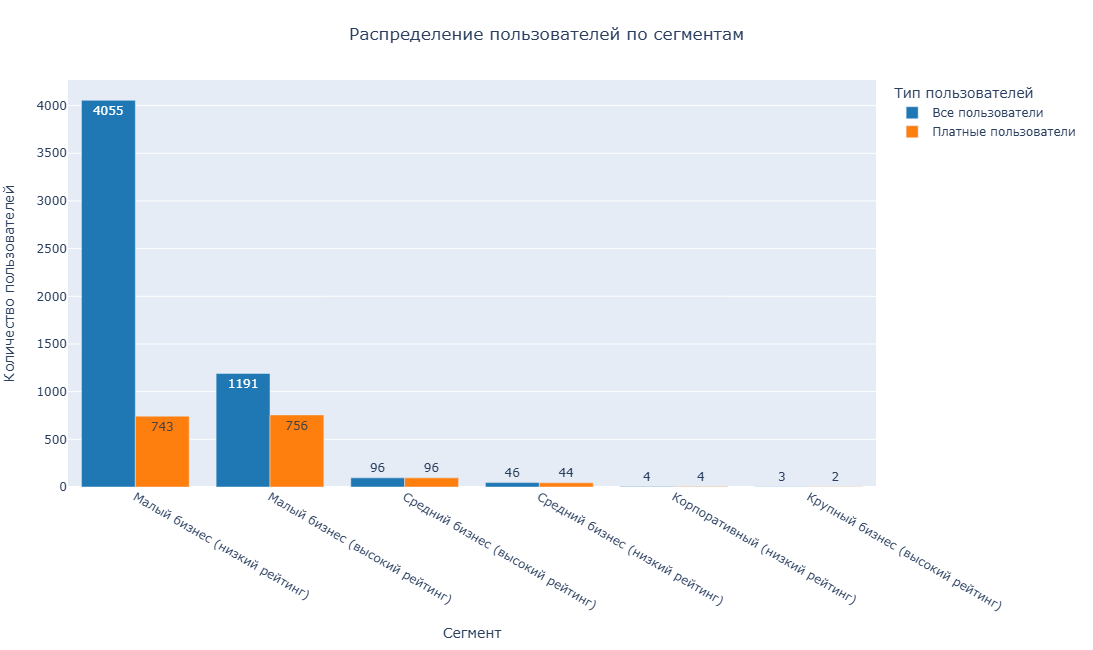

In [173]:
# создание DataFrame для графика
data = pd.DataFrame({
    'segment': segment_stats['segment'],
    'Все пользователи': segment_stats['count'],
    'Платные пользователи': segment_stats['paid_users']
})

data = data.melt(id_vars='segment', var_name='Тип пользователей', value_name='Количество пользователей')

# Используем Plotly Express для создания графика
fig = px.bar(data, 
             x='segment', 
             y='Количество пользователей', 
             color='Тип пользователей',
             barmode='group',
             title='Распределение пользователей по сегментам',
             color_discrete_sequence=["#1f77b4", "#ff7f0e"],
             text_auto=True # Добавляем значения на столбцы
            )

# Настройка Layout 
fig.update_layout(
    xaxis_title="Сегмент",
    yaxis_title="Количество пользователей",
    legend_title="Тип пользователей",
    margin=dict(l=20, r=20, t=80, b=20),
    title_x=0.5, # Центрирование заголовка
    font=dict(size=12), # Общий размер шрифта
    width=1100,
    height=650 
)

fig.show()

**Выводы по 5 разделу:**
- 1. Основную массу пользователей составляют представители малого бизнеса:
  - Малый бизнес (низкий рейтинг) – 4055 пользователей (самая большая группа).
  - Малый бизнес (высокий рейтинг) – 1191 пользователей.
- Это говорит о том, что сервис востребован среди небольших компаний, но значительная часть из них имеет низкий рейтинг (в среднем 4.34), что может указывать на проблемы с качеством отзывов или удовлетворённостью клиентов.

- 2. Средний бизнес – меньшая, но более активная группа
  - Средний бизнес (высокий рейтинг) – 96 пользователей, средний рейтинг 4.91, что свидетельствует о высоком качестве их услуг.
  - Средний бизнес (низкий рейтинг) – 46 пользователей,  их средний рейтинг (4.53) ниже порогового значения.
- Пользователи из этой категории используют больше виджетов (4.32–4.83) и дольше остаются на платформе (средняя длительность подписки 303–355 дней).

- 3. Крупный и корпоративный бизнес – редкие, но ресурсоёмкие клиенты
  - Крупный бизнес (высокий рейтинг) – 3 пользователя, используют в среднем 15 виджетов, рейтинг 4.81.
  - Корпоративный (низкий рейтинг) – 4 пользователя, но с очень высоким потреблением (48.25 виджетов).
- Эти группы демонстрируют высокую вовлечённость, но их мало, что может быть связано либо с высокой стоимостью сервиса, либо с узкой специализацией платформы.

- 4. Платёжеспособность и лояльность:
  - Наибольшая доля платных пользователей в сегментах "Средний бизнес" и "Крупный бизнес" (все пользователи этих групп оплачивают подписку).
  - Малый бизнес (высокий рейтинг) также показывает хорошую конверсию в платные подписки (756 из 1191).
  - Самый низкий уровень монетизации у "Малого бизнеса (низкий рейтинг)" – только 743 платных пользователей из 4055, что может быть связано с низкой вовлечённостью или недовольством сервисом.

---
**Сегментация подтвердила, что сервис популярен среди малого бизнеса, но требует доработок для повышения рейтингов и удержания клиентов. Средний и крупный бизнес, хотя и малочисленны, демонстрируют высокую лояльность и могут стать ключевым источником дохода.**

<a id="section-6"></a>
### 6 Выводы и рекомендации для заказчика 

**Общие выводы по исследованиям:**

- 1. `Пользователи и тарифы`

   - Бесплатный тариф доминирует (более 4000 пользователей), но конверсия в платные подписки крайне низкая (0,1%).

   - Платные пользователи (17,2% активных) в основном выбирают тарифы с 1-3 виджетами (Start, Medium). Тарифы с высокими лимитами (>10 виджетов) не востребованы.

   - Годовые подписки (Start/Medium/Expert) удерживают пользователей лучше, чем 3-месячные (отток 21-26% против 69%).

- 2. `Платежи и выручка`

  - Выручка выросла с 10 000 руб. (2021) до 370 000 руб. (2025), но рост обеспечен в основном притоком новых пользователей.

  - Средний чек выше у тарифов с большим количеством виджетов (до 26 000 руб.), но такие тарифы выбирают единицы.

  - В конце 2024 года рост выручки ускорился за счет увеличения доли тарифа Start 1 год (с 53,9% до 62,5%).

- 3. `Активность и удовлетворенность`

  - Платные пользователи ставят более высокие оценки (4.75-4.95 vs 4.73 у бесплатных).

  - Компании с высоким рейтингом реже уходят из сервиса.

  - `yaSprav` — главная платформа для отзывов (более 300 тыс.).

- 4. `LTV и отток`

  - Самый высокий LTV у нишевых тарифов («150 виджетов» — 593 666 руб.), но их используют 1-2 клиента.

  - Типичный LTV для массовых тарифов: 136 000–139 000 руб.

  - Профиль отточного пользователя:

    - Бесплатный тариф,

    - 1 виджет,

    - рейтинг < 4.7,

    - активен на Google Maps.

- 5. `Сегментация`

  - Малый бизнес (низкий рейтинг) — 4055 пользователей, низкая монетизация (743 платных).

  - Средний бизнес (высокий рейтинг) — 96 пользователей, средний рейтинг 4.91, что свидетельствует о высоком качестве их услуг.

  - Крупный бизнес — 7 пользователей, но используют 15 - 48 виджета.

---
**Основные проблемы:**

- 1. Критически низкая конверсия из триала (0.08%), обусловленная возможными ошибками в учетах триалов, либо о неэффективности триальной модели, либо триалом пользуются пользователи, не заинтересованные в дальнейшем использовании продукта.
- 2. Высокий отток с бесплатных и краткосрочных тарифов указывает на необходимость стимулирования перехода на годовые подписки.

---
**Рекомендации для бизнеса**

1. `Оптимизация тарифной сетки`

  - Упростить линейку тарифов:
   
    - Убрать нишевые тарифы с >10 виджетами (их почти не покупают).
      
    - Ввести гибкие планы, напрмер: Базовый (1-2 виджета), Профессиональный (3-5 виджетов), Бизнес (6-10 виджетов).
  
  - Стимулировать переход на годовые тарифы:
   
    - Скидка 20 - 25% за предоплату года.
    
    - Бесплатный месяц за переход с 3-месячного тарифа.


2. `Увеличение конверсии из триала`

  - Борьба с пользователи, не заинтересованные в дальнейшем использовании продукта:
   
    - Ввести обязательную верификацию для триала: SMS-подтверждение (1 номер = 1 аккаунт), запрет временных email-сервисов, лимит триалов с одного IP/устройства (например, 1 раз в 6 месяцев).
     
    - Сократить срок бесплатного периода:  14 дней  до 3–7 дней. Этого достаточно для теста, но недостаточно для постоянного использования.
      
    - Ограничить функционал в триале, напрмер доступ только к одному виджету.
      
    - Внедрить тариф "1 рубль за тест" вместо полностью бесплатного.
      
    - Запустить A/B-тест — например, для 50% новых пользователей сделайть триал платным (1 рубль), а для остальных оставить текущий вариант. Через месяц сравнить конверсию.

  - Стимулы для перехода на платную версию:
    
    - Персонализированные предложения после триала, например если пользователь активно отвечал на отзывы, предложить ему любой тариф с бонусным месяцем.


3. `Удержание платных пользователей`

  - Автопродление с бонусами:
    
    - -20% за годовой платеж или помесячный.
      
    - +1 бесплатный виджет за каждый оплаченный год.
   
  -  Программа лояльности:
    
     -  Баллы за отзывы, которые можно обменять на дополнительные виджеты или скидку.
   
4. `Дополнительные рекомендации с учетом сегментации:`

  - Для "Малого бизнеса (низкий рейтинг)":
 
    - Персонализированные предложения: предлагать тарифы, которые соответствуют их потребностям и бюджету (например, тариф "Start" с ограниченным набором виджетов
   
    - Активно собирать обратную связь от этих пользователей, чтобы понять причины их низкой вовлеченности и неудовлетворенности.
   
  - Для "Среднего бизнеса (высокий рейтинг)":
 
    - Предлагать расширенные тарифы с большим количеством виджетов и приоритетной поддержкой.
   
  - Для "Крупного бизнеса":
 
    - Предлагать индивидуальные тарифные планы и решения, адаптированные под их специфические потребности.

---
**Приоритизация рекомендаций:**

1. `Высокий приоритет:`

  - Оптимизация тарифной сетки (упрощение и стимуляция годовых подписок).
    
  - Улучшение конверсии из триала (борьба с нецелевыми пользователями, сокращение срока триала, A/B-тест).
 
2. `Средний приоритет:`

  - Удержание платных пользователей (автопродление с бонусами, программа лояльности).
  
  - Разработка персонализированных предложений для "Малого бизнеса (низкий рейтинг)".
 
3. `Низкий приоритет:`

  - Разработка индивидуальных тарифных планов для "Крупного бизнеса".  